# <u>Projet 7: "Implémentez un modèle de scoring" - Analyse Exploratoire<u>

## Description des données:

Les données sont fournies par Home Credit, un service dédié à l'accord de prêts bancaires à la population non bancarisée. Prédire si un client remboursera un prêt ou si il aura des difficultés à le faire est un besoin essentiel de l'entreprise, et Home Credit a organisé une compétition sur Kaggle pour voir quel type de modèles de Machine Learning peuvent aider à effectuer ces prédictions.

Il y a 7 types de tables:

**application_train/application_test :** les principales données d'entrâinement et de test. Informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de demande d'entraînement sont accompagnées de la variable TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.

**bureau :** données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans la table bureau, mais un prêt dans la table application peut avoir plusieurs crédits précédents.
    
**bureau_balance :** données mensuelles concernant les crédits précédents dans le bureau. Chaque ligne correspond à un mois de crédit précédent, et un crédit précédent unique peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
    
**previous_application :** demandes précédentes de prêts au Home Credit des clients qui ont des prêts dans la table applcation. Chaque prêt actuel dans application peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
    
**POS_CASH_BALANCE :** données mensuelles sur les prêts au point de vente (pos) ou au comptant (cash) que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt cash précédent, et un seul prêt précédent peut avoir plusieurs lignes.
    
**credit_card_balance :** données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
​
**installments_payment :** historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 14.0
import matplotlib.patches as mpatches

import numpy as np

import warnings
warnings.filterwarnings('ignore')

# <u>I. Analyses descriptives

In [2]:
def missing_values_table(df, size=20):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0]\
        .sort_values('% of Total Values', ascending=False).round(1)
        
        print (f"Le Dataframe a " + str(df.shape[1]) + " colonnes.\n"      
            "Il y a " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes ayant des valeurs manquantes")
        
        plt.figure(figsize=(10,size))
        sns.heatmap(mis_val_table_ren_columns.drop('Missing Values', axis=1),
                    annot=True, vmin = 0, vmax = 100, center=50, cmap='gist_heat')
        
        return mis_val_table_ren_columns


## <u>I.A. Exploration de la table application

Les tables application_train et application_test sont constituées d'informations générales sur les prêts effectués. Il y a un prêt par ligne.

### <u>I.A.1 Remplissage et redimensionnement de la table application

In [3]:
app_train = pd.read_csv("application_train.csv")
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [4]:
print('Taille du dataframe: ', app_train.shape)

Taille du dataframe:  (307511, 122)


In [5]:
app_test = pd.read_csv("application_test.csv")
app_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [6]:
print('Taille du dataframe: ', app_test.shape)

Taille du dataframe:  (48744, 121)


Le Dataframe a 122 colonnes.
Il y a 67 colonnes ayant des valeurs manquantes


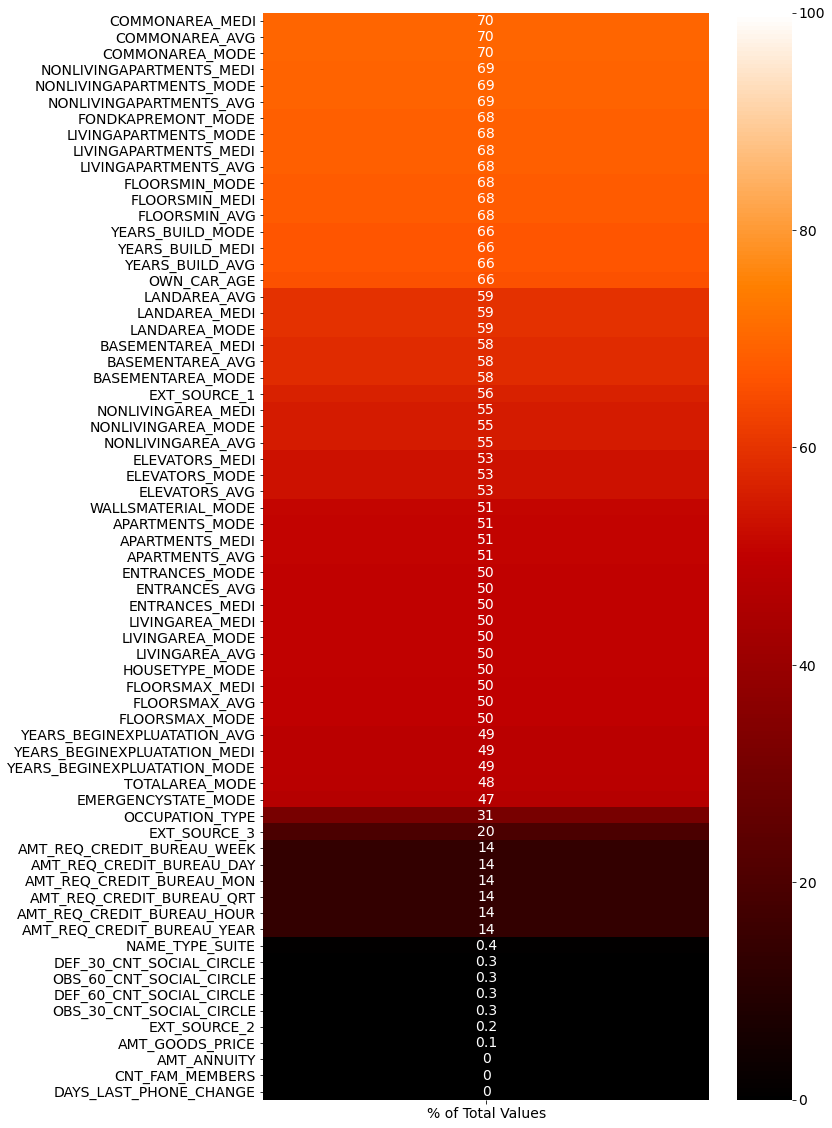

In [7]:
app_train_missing = missing_values_table(app_train)

Nous allons supprimer les variables pour lesquelles on observe plus de 50% de valeurs manquantes.

In [8]:
empty_features = app_train_missing[app_train_missing['% of Total Values'] > 40].index

In [9]:
app_train = app_train.drop(empty_features, axis=1)
app_test = app_test.drop(empty_features, axis=1)

In [10]:
app_train.dtypes.value_counts()

int64      41
float64    20
object     12
dtype: int64

In [11]:
app_train_missing = missing_values_table(app_train, size=8)

Le Dataframe a 73 colonnes.
Il y a 18 colonnes ayant des valeurs manquantes


Dans la plupart des Notebooks kaggle ainsi que dans les premiers essais effectués avant ce notebook, les variables relatives aux enquêtes ont peu d'importance dans les modèles scoring. Nous choisirons de les supprimer, étant donné qu'en plus ces variables sont mal renseignées.

Certaines variables (flag_document...) ne sont pas directement compréhensibles et ne sont également pas importantes pour des modèles vu précedemment.
D'autre variables sont difficilement interprétables, comme EXT_SOURCE_1, EXT_SOURCE2, EXT_SOURCE_3, néanmoins ce sont des variables généralement très importantes dans les modèles d'apprentissages des compétiteurs Kaggle.

In [12]:
irrelevant_features = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR']

In [13]:
app_train = app_train.drop(irrelevant_features, axis=1)
app_test = app_test.drop(irrelevant_features, axis=1)

Il faudrait imputer certaines valeurs manquantes

In [14]:
app_train_missing = missing_values_table(app_train, size=4)

Le Dataframe a 47 colonnes.
Il y a 12 colonnes ayant des valeurs manquantes


Le Dataframe a 46 colonnes.
Il y a 9 colonnes ayant des valeurs manquantes


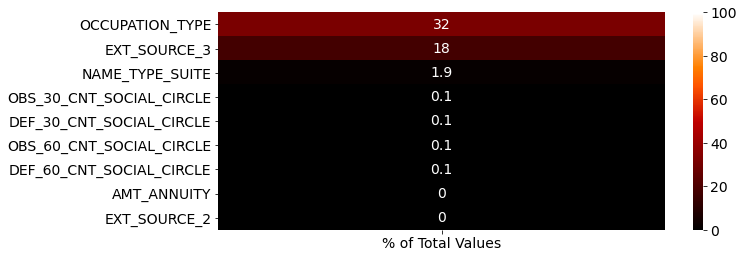

In [15]:
app_test_missing = missing_values_table(app_test, size=4)

Nous réaliserons les imputations de ces valeurs manquantes au cas par cas lors de l'analyse exploratoire

In [16]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_C

In [17]:
obj_features_tab = app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
obj_features_tab

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

Certaines variables de type numériques n'ont que très peu de valeurs. Ce sont peut-être des variables qualitatives ordinales.

In [18]:
num_features_tab = app_train.select_dtypes(['float64', 'int64']).apply(pd.Series.nunique, axis = 0)
num_features_tab

SK_ID_CURR                     307511
TARGET                              2
CNT_CHILDREN                       15
AMT_INCOME_TOTAL                 2548
AMT_CREDIT                       5603
AMT_ANNUITY                     13672
AMT_GOODS_PRICE                  1002
REGION_POPULATION_RELATIVE         81
DAYS_BIRTH                      17460
DAYS_EMPLOYED                   12574
DAYS_REGISTRATION               15688
DAYS_ID_PUBLISH                  6168
FLAG_MOBIL                          2
FLAG_EMP_PHONE                      2
FLAG_WORK_PHONE                     2
FLAG_CONT_MOBILE                    2
FLAG_PHONE                          2
FLAG_EMAIL                          2
CNT_FAM_MEMBERS                    17
REGION_RATING_CLIENT                3
REGION_RATING_CLIENT_W_CITY         3
HOUR_APPR_PROCESS_START            24
REG_REGION_NOT_LIVE_REGION          2
REG_REGION_NOT_WORK_REGION          2
LIVE_REGION_NOT_WORK_REGION         2
REG_CITY_NOT_LIVE_CITY              2
REG_CITY_NOT

### <u>I.A.2 Variable cible

**TARGET: Difficulté de paiement ou pas ?**

La variable TARGET renseigne:
- si le prêt a été payé sans problèmes (0),
- si il y a eu des difficultés de paiement pour ce prêt (1).

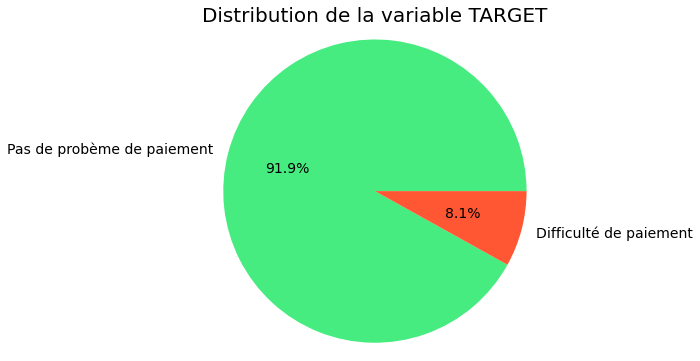

In [19]:
labels = 'Pas de probème de paiement', 'Difficulté de paiement'
sizes = app_train.TARGET.value_counts().values
colors = ['#47EC80', '#FF5733']

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
ax1.axis('equal')

ax1.set_title('Distribution de la variable TARGET', size=20)
plt.show()

### <u>I.A.3 Fonctions d'affichage des statistiques pour l'analyse exploratoire des variables qualitatives

In [20]:
def plot_pie_dist(df, var, ax, id_var, colors):
    
    count = df.groupby(var)[id_var].count()
    labels = count.index
    sizes = count.values

    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
    ax.axis('equal')
    ax.set_title(f'Distribution de la variable {var}', size=18)

In [21]:
def plot_bar_dist(df, var, ax, id_var, colors):
    
    count = df.groupby(var)[id_var].count()
    labels = list(count.index)
    height = list(count.values)
    x = np.arange(len(labels))
    
    ax.bar(x, height, color=colors, tick_label=labels)
    ax.set_title(f'Distribution de la variable {var}', size=18)

In [22]:
def plot_stacked_bars(df, var, ax, id_var='SK_ID_CURR'):
    
    labels = df.groupby(var)[id_var].count().index
    
    default_tab = df[df.TARGET==1].groupby(var)[id_var].count()
    no_default_tab = df[df.TARGET==0].groupby(var)[id_var].count()
    total_tab = df.groupby(var)[id_var].count()

    default = []
    no_default = []
    for i, index in enumerate(total_tab.index):
        if index in default_tab.index:
            default.append(default_tab[index]/total_tab[index]*100)
        else:
            default.append(0)

        if index in no_default_tab.index:
            no_default.append(no_default_tab[index]/total_tab[index]*100)
        else:
            no_default.append(0)
        
    ax.bar(labels, no_default, data=df, color='#47EC80', label='Pas de problèmes de paiement', bottom=default)
    ax.bar(labels, default, data=df, color='#FF5733', label='Difficulté de paiement')

    ax.set_title(f'Taux (%) de difficulté de paiement par {var}', size=18)
    ax.legend()

In [23]:
def plot_bars(df, var, ax, id_var='SK_ID_CURR'):
    
    labels = df.groupby(var)[id_var].count().index
    
    default_tab = df[df.TARGET==1].groupby(var)[id_var].count()
    total_tab = df.groupby(var)[id_var].count()

    default = []
    
    for i, index in enumerate(total_tab.index):
        if index in default_tab.index:
            default.append(default_tab[index]/total_tab[index]*100)
        else:
            default.append(0)
            
    ax.bar(labels, default, data=df, color='#FF5733', label='Difficulté de paiement')

    ax.set_title(f'Taux (%) de difficulté de paiement par {var}', size=18)
    ax.legend()

In [24]:
def categ_var_plots(df, var, id_var='SK_ID_CURR', colors=['#E28CF5','#47A6EC']):
    
    if df[var].nunique() <=2:
        
        fig, axs = plt.subplots(2,2, figsize=(15,15))
        plot_pie_dist(df, var, axs[0,0], id_var, colors)
        plot_bar_dist(df, var, axs[0,1], id_var, colors)
        plot_stacked_bars(df, var, axs[1,0], id_var)
        plot_bars(df, var, axs[1,1], id_var)
        plt.tight_layout()
        plt.show()
        
    elif 2 < df[var].nunique() <=10:
        
        fig, axs = plt.subplots(3,1, figsize=(20,15))
        plot_bar_dist(df, var, axs[0], id_var, colors)
        plot_stacked_bars(df, var, axs[1], id_var)
        plot_bars(df, var, axs[2], id_var)
        plt.tight_layout()
        plt.show()
    
    else: 
        
        fig, axs = plt.subplots(1,2, figsize=(20,30))
        
        ####### Premier graphique #######
        count = df.groupby(var)[id_var].count()
        labels = list(count.index)
        height = list(count.values)
        x = np.arange(len(labels))

        axs[0].barh(x, height, color=colors, tick_label=labels)
        axs[0].set_title(f'Distribution de la variable {var}', size=18)
        
        ####### Second graphique #######
        labels = df.groupby(var)[id_var].count().index
    
        default_tab = df[df.TARGET==1].groupby(var)[id_var].count()
        total_tab = df.groupby(var)[id_var].count()

        default = []

        for i, index in enumerate(total_tab.index):
            if index in default_tab.index:
                default.append(default_tab[index]/total_tab[index]*100)
            else:
                default.append(0)

        axs[1].barh(labels, default, data=df, color='#FF5733', label='Difficulté de paiement')

        axs[1].set_title(f'Difficulté de paiement (%) par {var}', size=18)
        axs[1].legend()
        
        plt.tight_layout()

### <u>I.A.4 Analyse descriptives des variables qualitatives

Certaines variables numériques sont en réalité catégorielles: si elle ont entre 2 et 5 valeurs différentes, nous les considèrerons comme étant des variables qualitatives ordinales

In [25]:
obj_features_tab

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

In [26]:
num_features_tab = app_train.select_dtypes(['float64', 'int64']).apply(pd.Series.nunique, axis = 0)
num_features_tab[num_features_tab.values < 5]

TARGET                         2
FLAG_MOBIL                     2
FLAG_EMP_PHONE                 2
FLAG_WORK_PHONE                2
FLAG_CONT_MOBILE               2
FLAG_PHONE                     2
FLAG_EMAIL                     2
REGION_RATING_CLIENT           3
REGION_RATING_CLIENT_W_CITY    3
REG_REGION_NOT_LIVE_REGION     2
REG_REGION_NOT_WORK_REGION     2
LIVE_REGION_NOT_WORK_REGION    2
REG_CITY_NOT_LIVE_CITY         2
REG_CITY_NOT_WORK_CITY         2
LIVE_CITY_NOT_WORK_CITY        2
dtype: int64

**Variable CODE_GENDER**

In [27]:
app_train.groupby('CODE_GENDER')['SK_ID_CURR'].count().reset_index()

CODE_GENDER  SK_ID_CURR
0           F      202448
1           M      105059
2         XNA           4

Nous choisirons de ne pas considérer les 'XNA'.

In [28]:
app_test.groupby('CODE_GENDER')['SK_ID_CURR'].count().reset_index()

CODE_GENDER  SK_ID_CURR
0           F       32678
1           M       16066

In [29]:
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']
app_train.groupby('CODE_GENDER')['SK_ID_CURR'].count().reset_index()

CODE_GENDER  SK_ID_CURR
0           F      202448
1           M      105059

In [30]:
app_train.CODE_GENDER.nunique()

2

In [31]:
categ_var_plots(app_train, 'CODE_GENDER')

Il y a nettement moins d'hommes qui demandent un prêt à Home Credit, néanmoins les femmes ont plus de facilité à rembourser leur prêt.

**Type de prêt: Prêt direct à court terme (Cash Loan) ou prêt renouvelable (Revolving loan)**

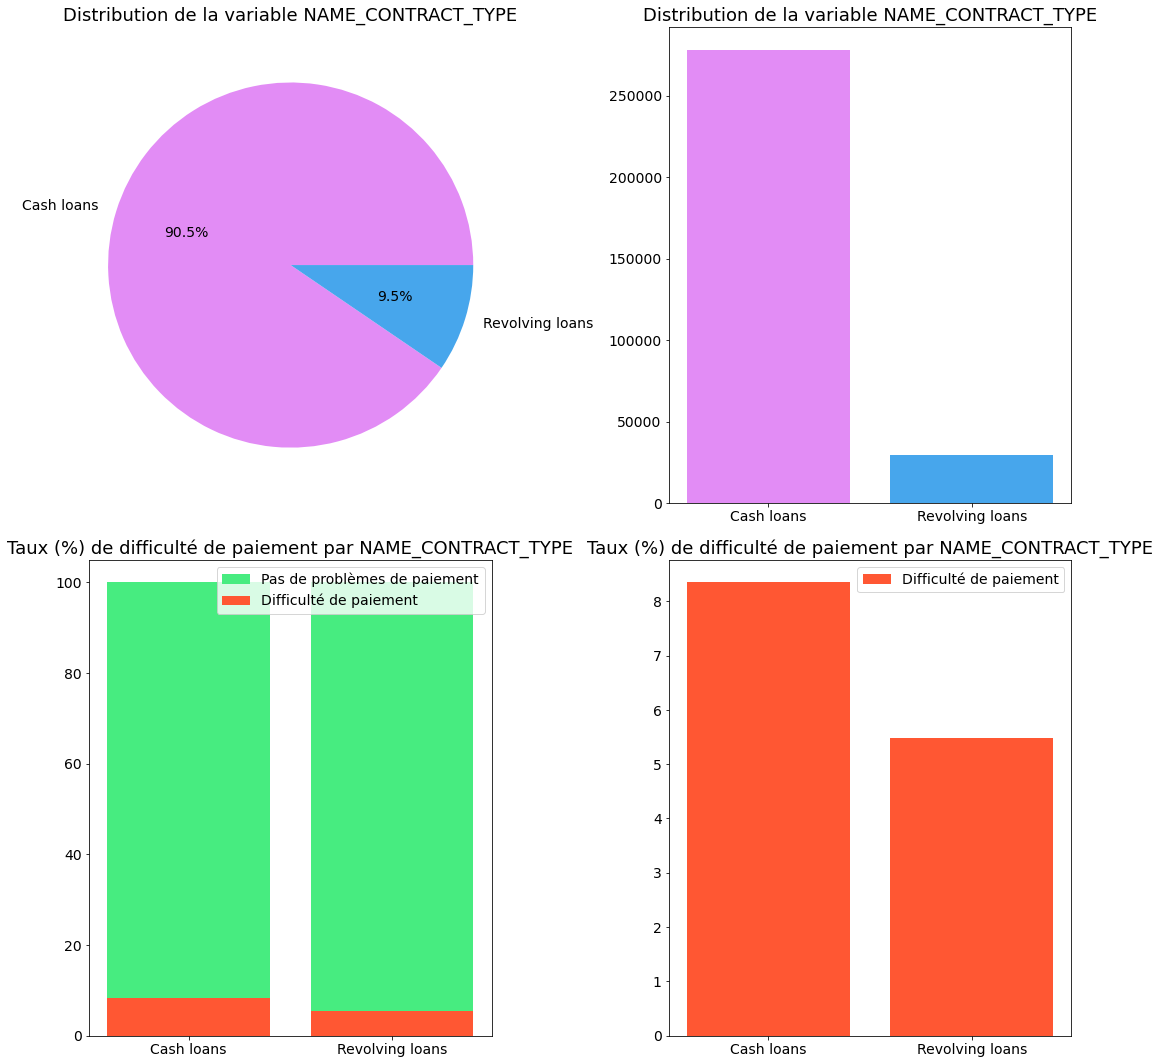

In [32]:
categ_var_plots(app_train, 'NAME_CONTRACT_TYPE')

Un client a en général plus de difficultés à repayer son prêt lorsqu'il s'agit d'un prêt direct.

**Variable indiquant si un client possède une voiture**

In [33]:
categ_var_plots(app_train, 'FLAG_OWN_CAR')

La plupart de possède pas de voiture. Il semble plus difficile de rembourser son crédit lorsque l'on e possède pas de voiture.

**Variable indiquant si un client possède une propriété (immobilier)**

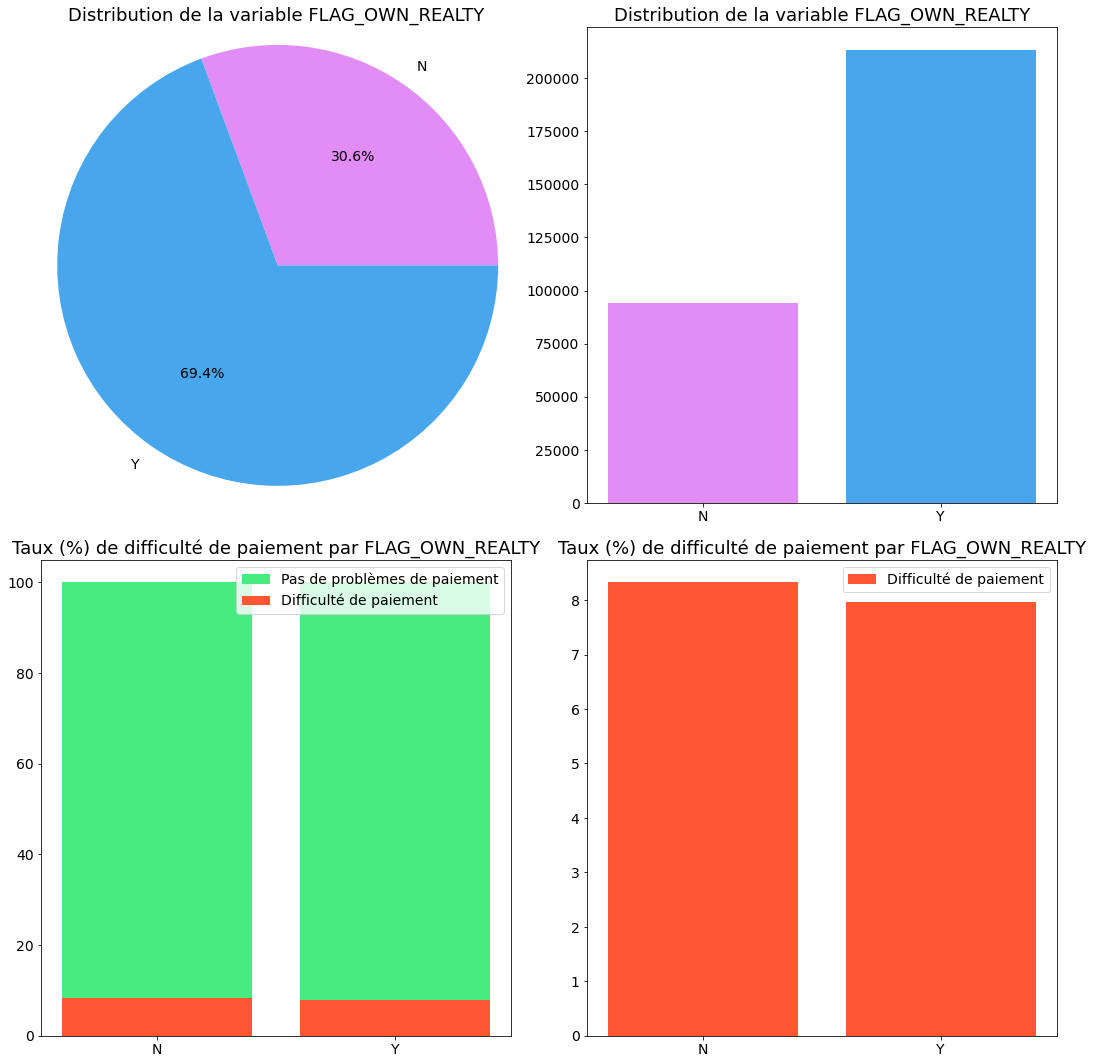

In [34]:
categ_var_plots(app_train, 'FLAG_OWN_REALTY')

Peu de différence de défaut de paiement, que le client ait une propriété ou pas.

**Accompagnement du client lors de la demande de prêt**

In [35]:
app_train['NAME_TYPE_SUITE'] = app_train['NAME_TYPE_SUITE'].fillna('Other')
app_test['NAME_TYPE_SUITE'] = app_test['NAME_TYPE_SUITE'].fillna('Other')

In [36]:
app_train['NAME_TYPE_SUITE'] = app_train['NAME_TYPE_SUITE'].replace({'Other_A':'Other','Other_B':'Other'})
app_test['NAME_TYPE_SUITE'] = app_test['NAME_TYPE_SUITE'].replace({'Other_A':'Other','Other_B':'Other'})

In [37]:
categ_var_plots(app_train, 'NAME_TYPE_SUITE')

Très peu d'influence de l'accompagnement lors de la demande de prêt

**Type de revenu**

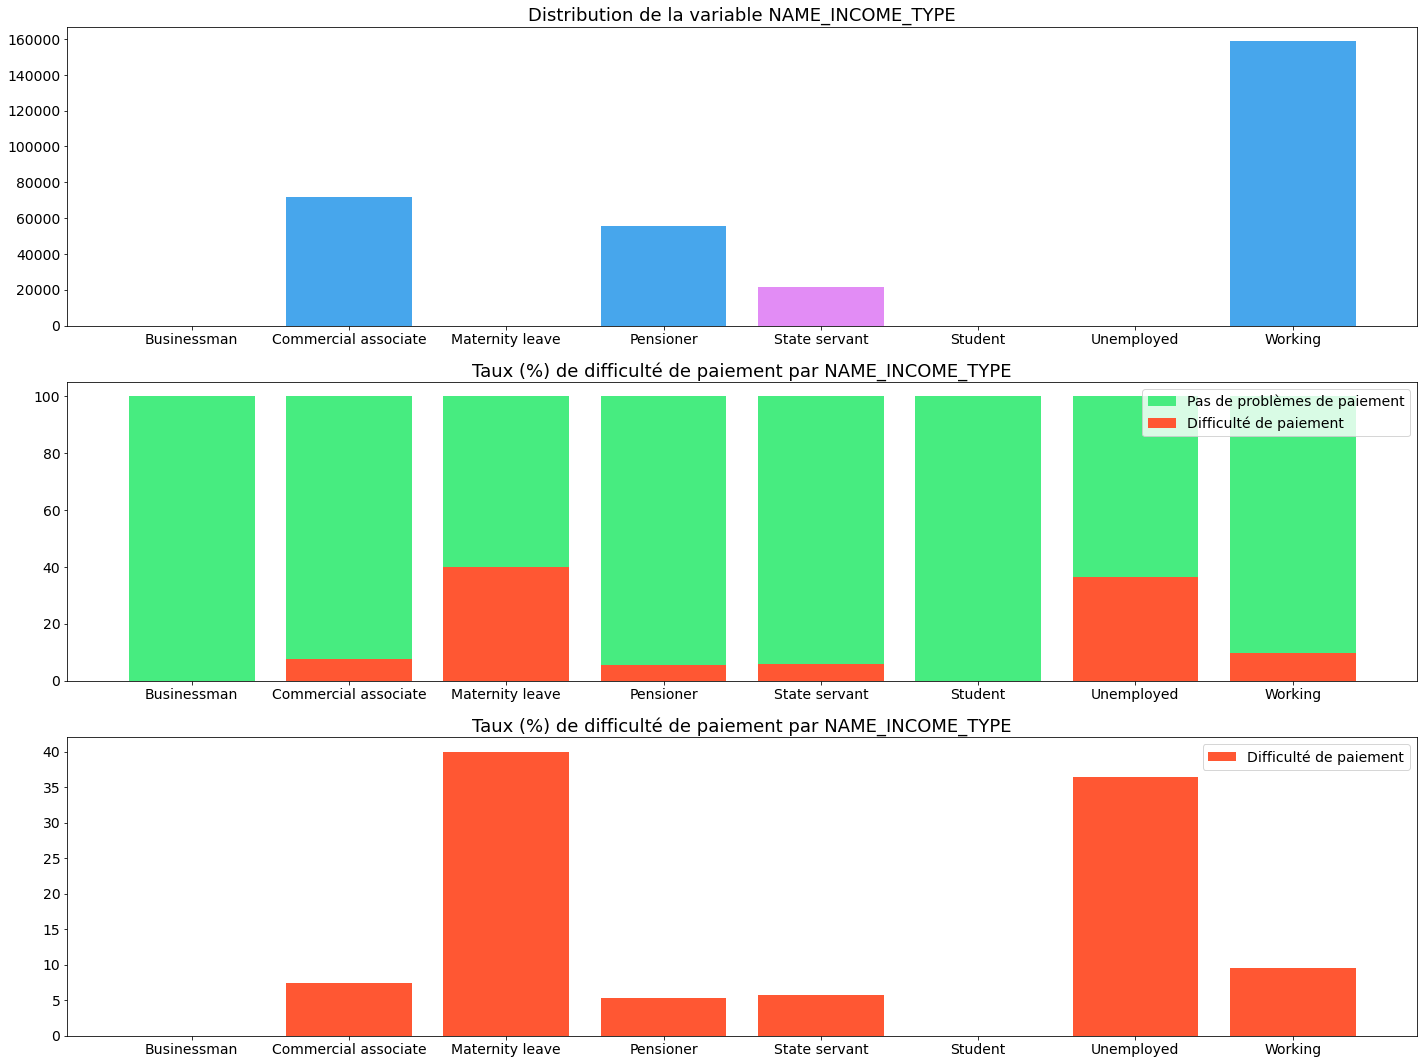

In [38]:
categ_var_plots(app_train, 'NAME_INCOME_TYPE')

**Situation familiale**

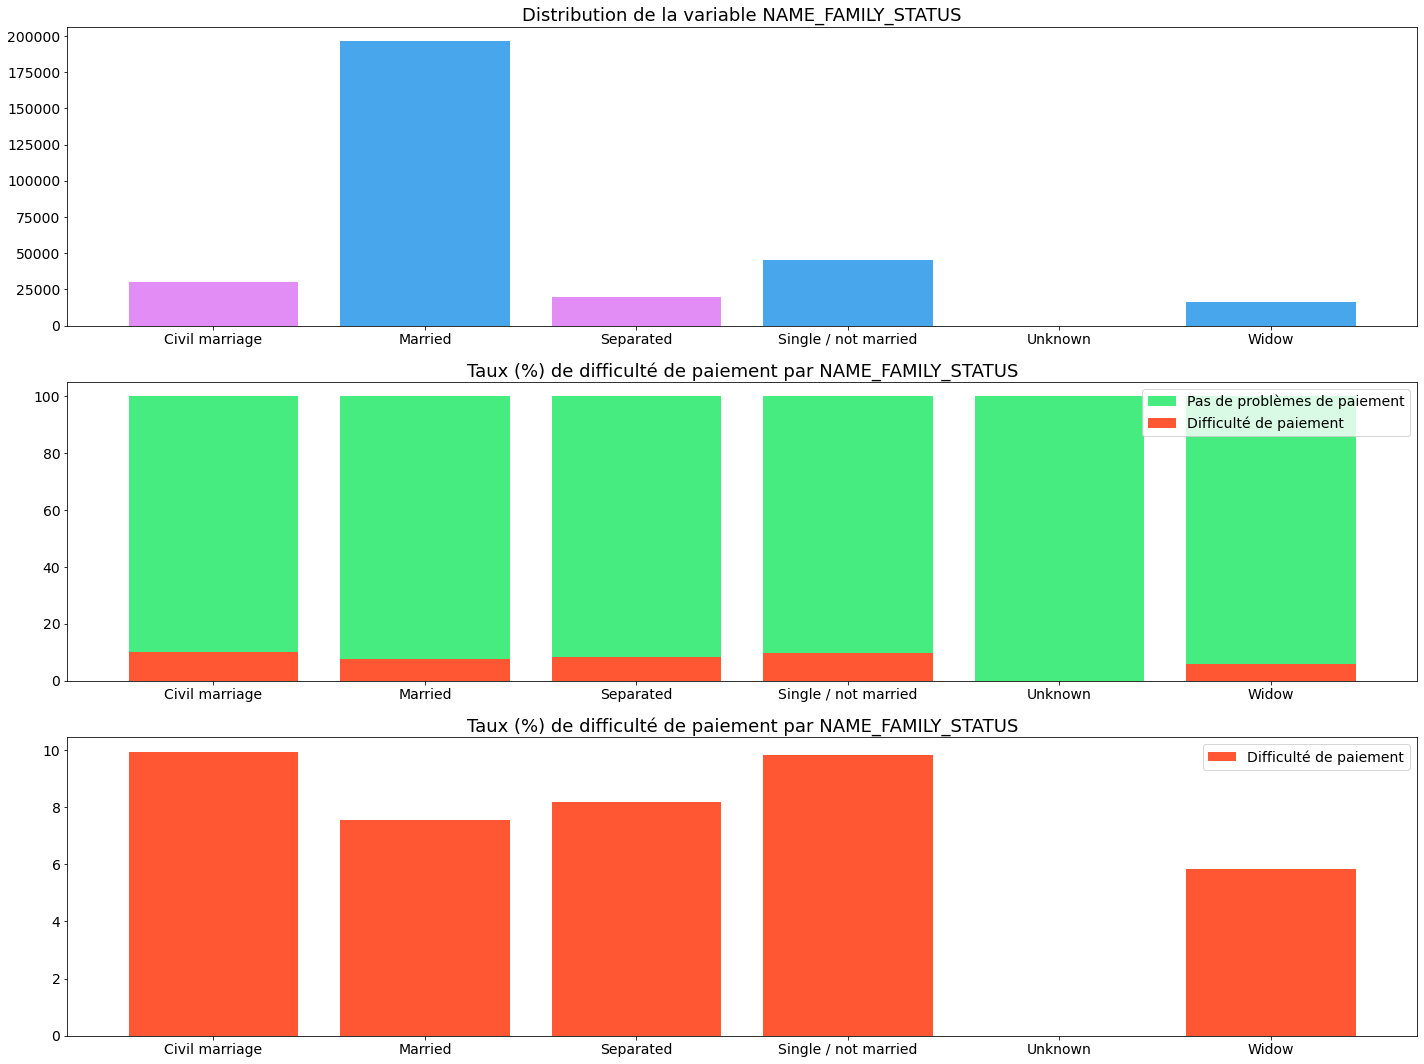

In [39]:
categ_var_plots(app_train, 'NAME_FAMILY_STATUS')

Un client marrié a plus de chance de rembourser qu'un client séparé, en union civile ou célibataire.

**Type d'habitation**

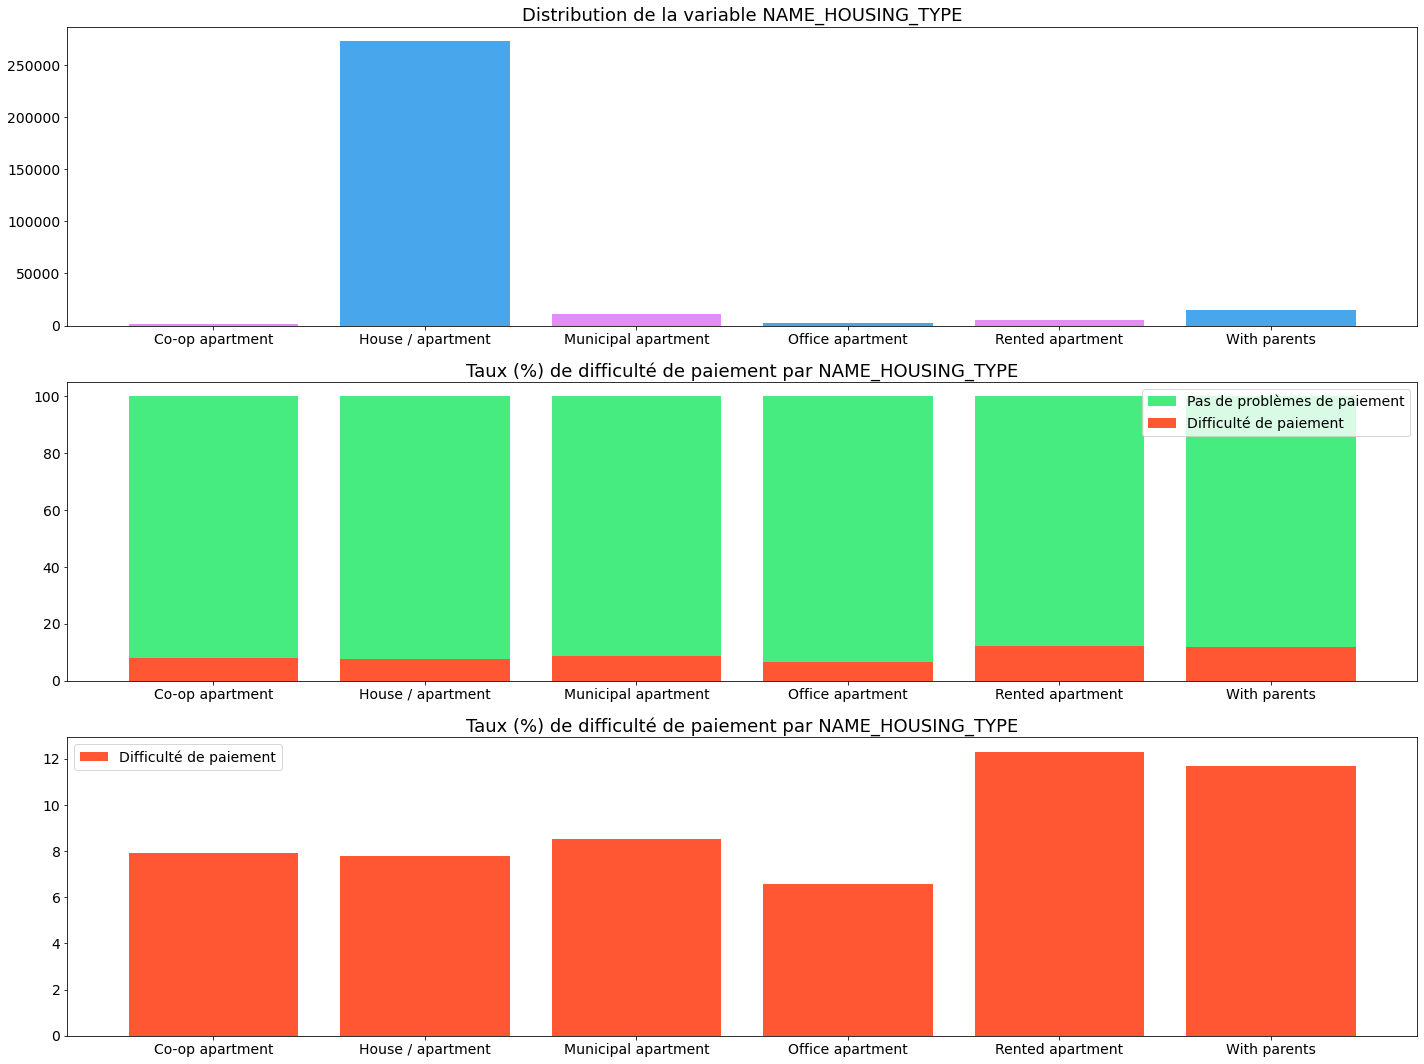

In [40]:
categ_var_plots(app_train, 'NAME_HOUSING_TYPE')

PLus de chance de rembourser lorsqu'on vit seul en maison ou appartement que lorsqu'on est hebergé par les parents ou que l'on est logé via une rente. Cela est corrélé à l'indépendance financière du client.

**Jour de début du processus de prêt**

In [41]:
categ_var_plots(app_train, 'WEEKDAY_APPR_PROCESS_START')

Nous supprimerons cette variable qui pourrait biaiser les résultats. Il n'y a aucune raison de penser que le jour ait une influence sur la façon dont est prêt est remboursé.

In [42]:
app_train = app_train.drop('WEEKDAY_APPR_PROCESS_START', axis=1)
app_test = app_test.drop('WEEKDAY_APPR_PROCESS_START', axis=1)

**Niveau d'éducation**

In [43]:
categ_var_plots(app_train, 'NAME_EDUCATION_TYPE')

Le niveau d'éducation est un indicateur clé pour la prise de décision d'accord de crédit.
Cette variable peut être encodée de façon ordinale, il faudra y penser lors de la phase de prétraitement avant la modélisation.

**Activité professionelle**

Remplaçons les valeurs manquantes

In [44]:
app_train['OCCUPATION_TYPE'] = app_train['OCCUPATION_TYPE'].fillna('unknown')
app_test['OCCUPATION_TYPE'] = app_test['OCCUPATION_TYPE'].fillna('unknown')

In [45]:
categ_var_plots(app_train, 'OCCUPATION_TYPE')

L'activité professionnelle a un impact déterminantpour l'accord d'un crédit. Il peut être possible d'ordonner cette variable sur la base d'un classement par type d'activité professionelle.

In [46]:
app_train_missing = missing_values_table(app_test, size=4)

Le Dataframe a 45 colonnes.
Il y a 7 colonnes ayant des valeurs manquantes


Type d'entreprise

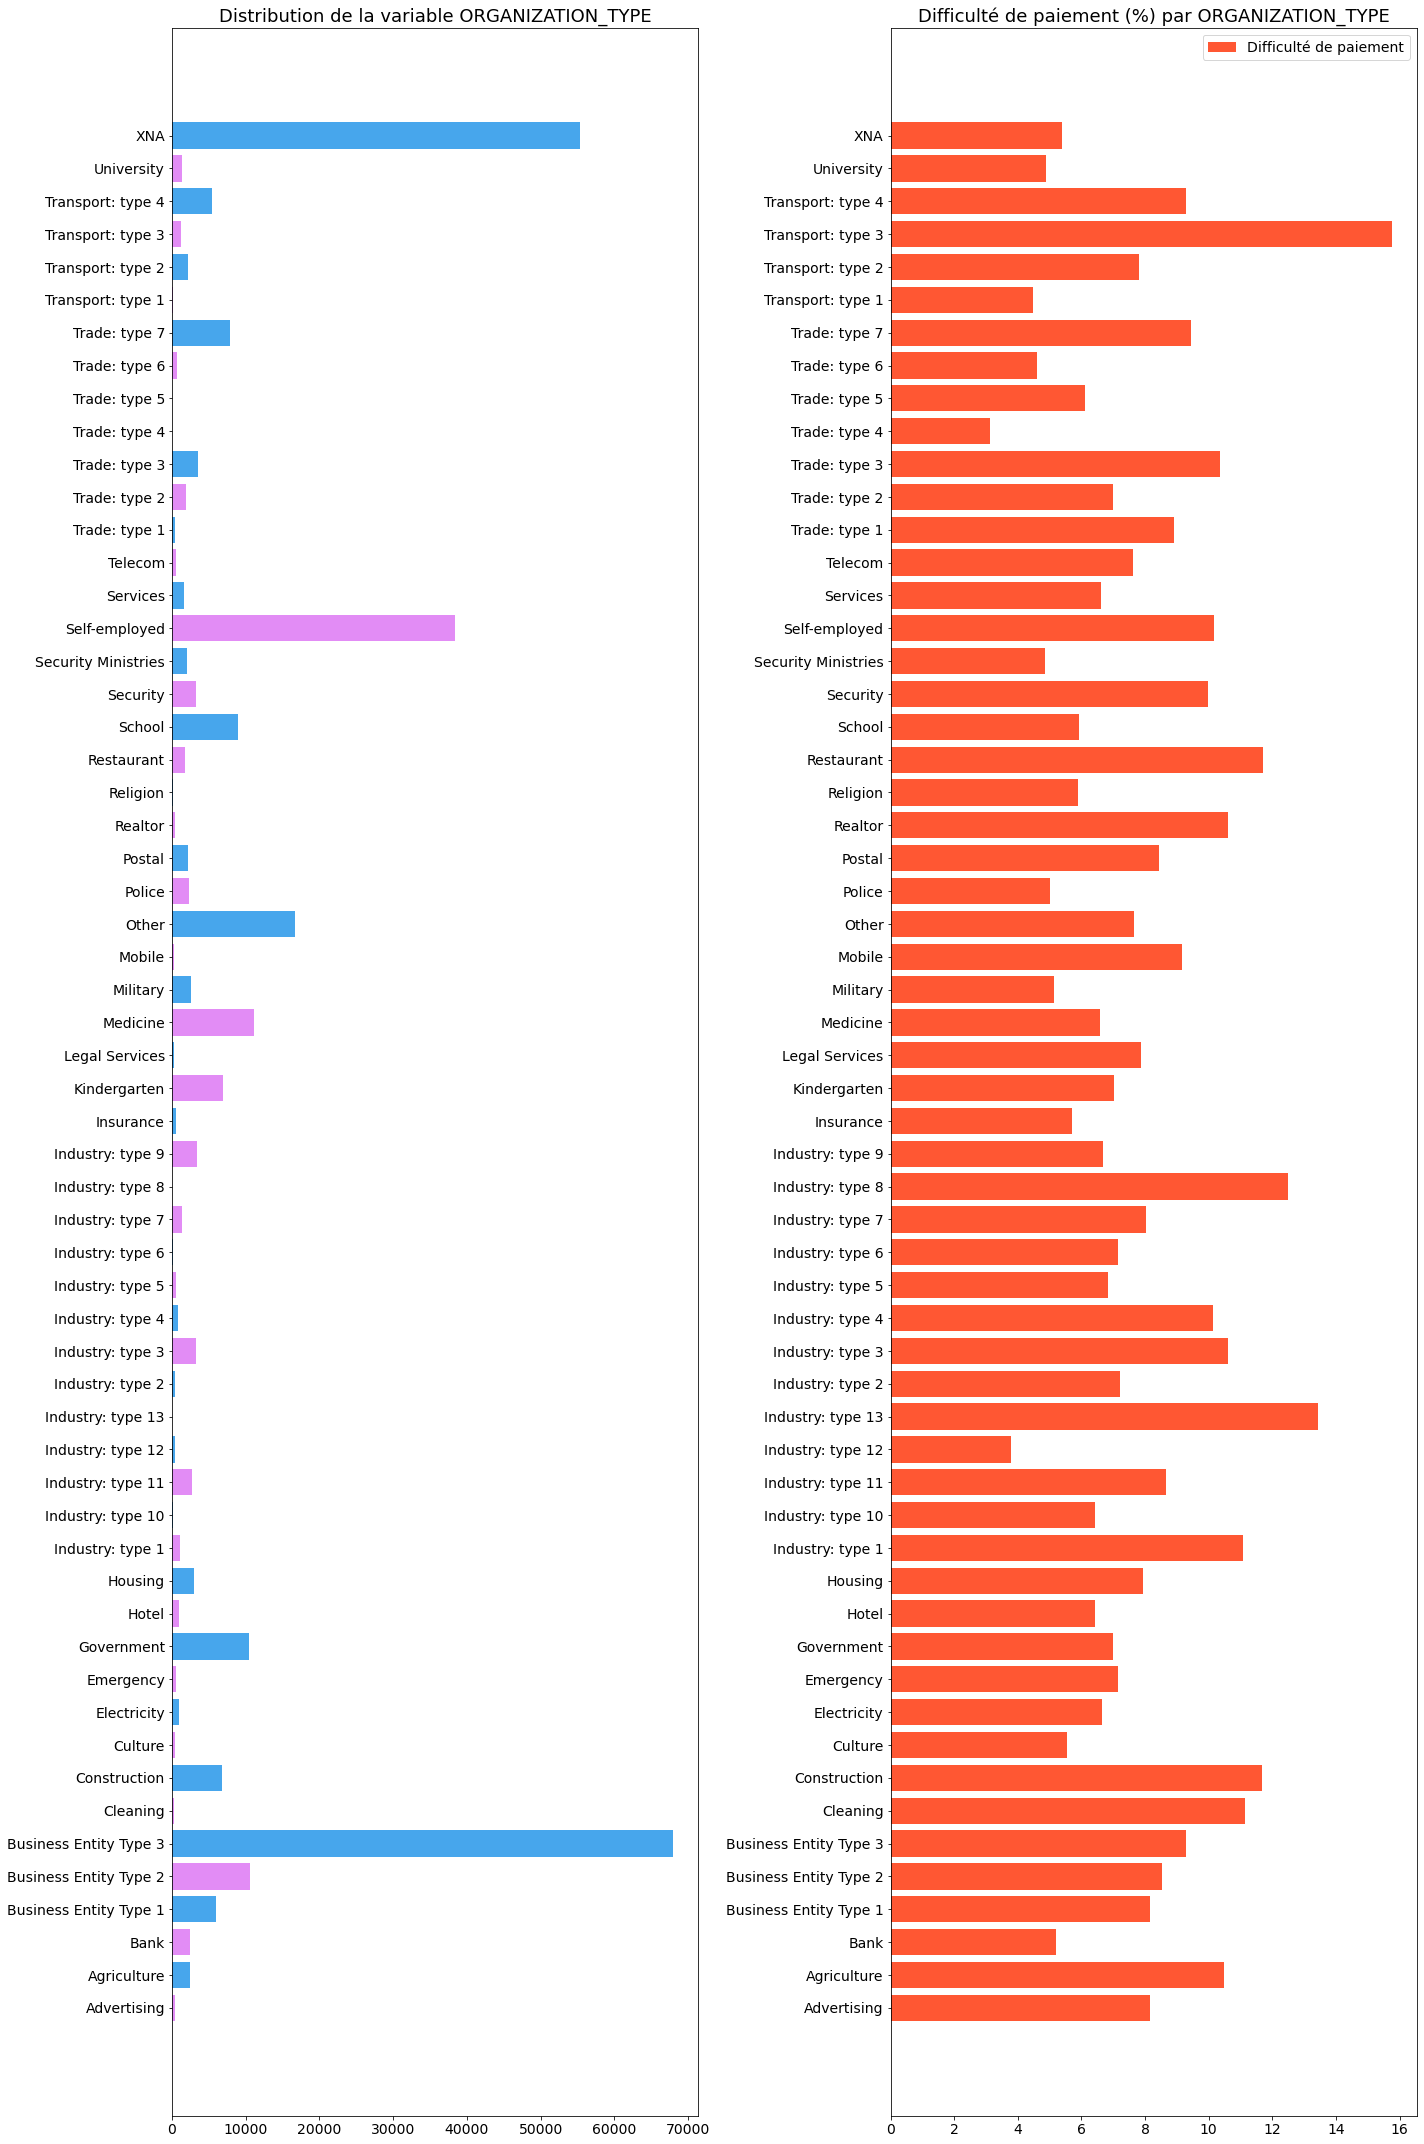

In [47]:
categ_var_plots(app_train, 'ORGANIZATION_TYPE')

**N° de tél mobile fourni par le client**

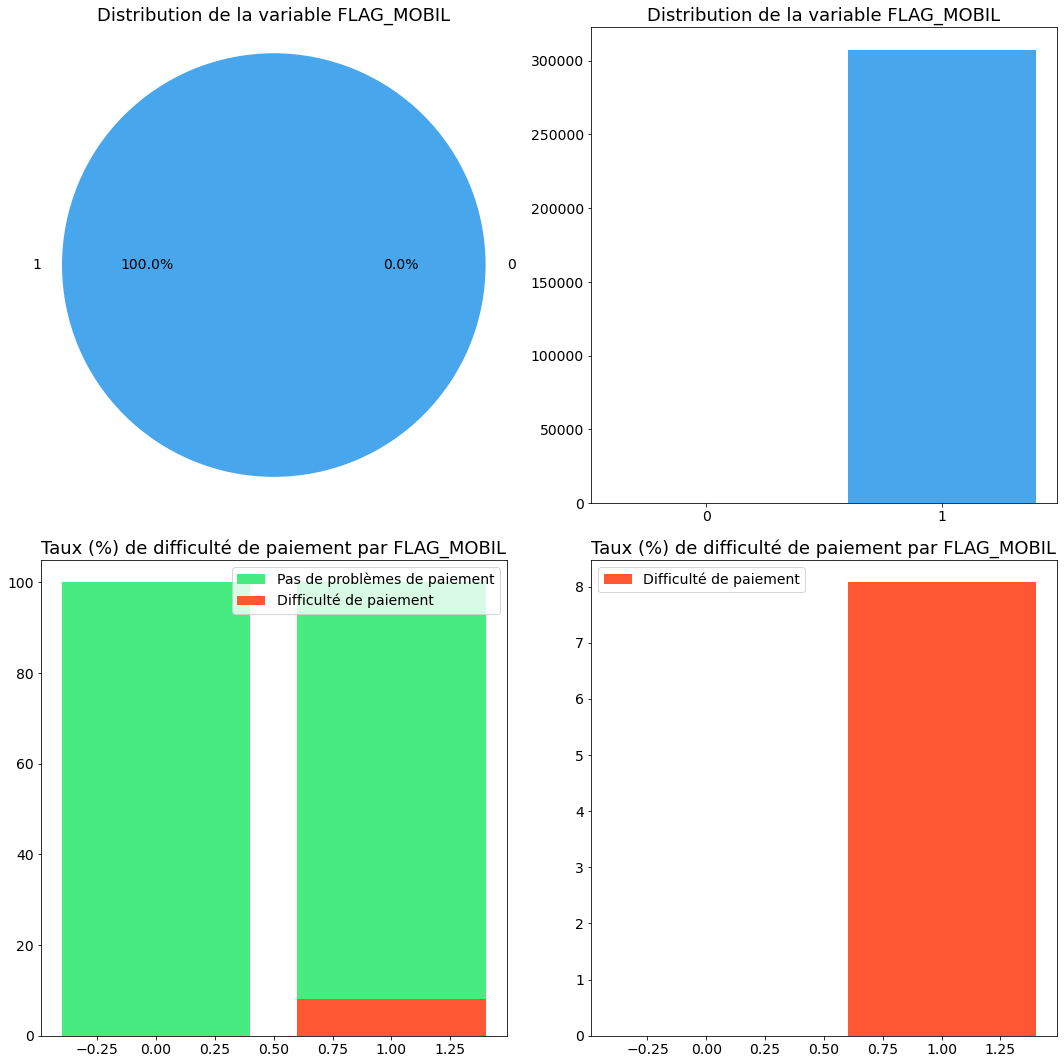

In [48]:
categ_var_plots(app_train, 'FLAG_MOBIL')

Il n'y a pas de variance, nous allons donc supprimer cette variable.

In [49]:
app_train = app_train.drop('FLAG_MOBIL', axis=1)
app_test = app_test.drop('FLAG_MOBIL', axis=1)

**N° de tél de l'employeur fourni par le client**

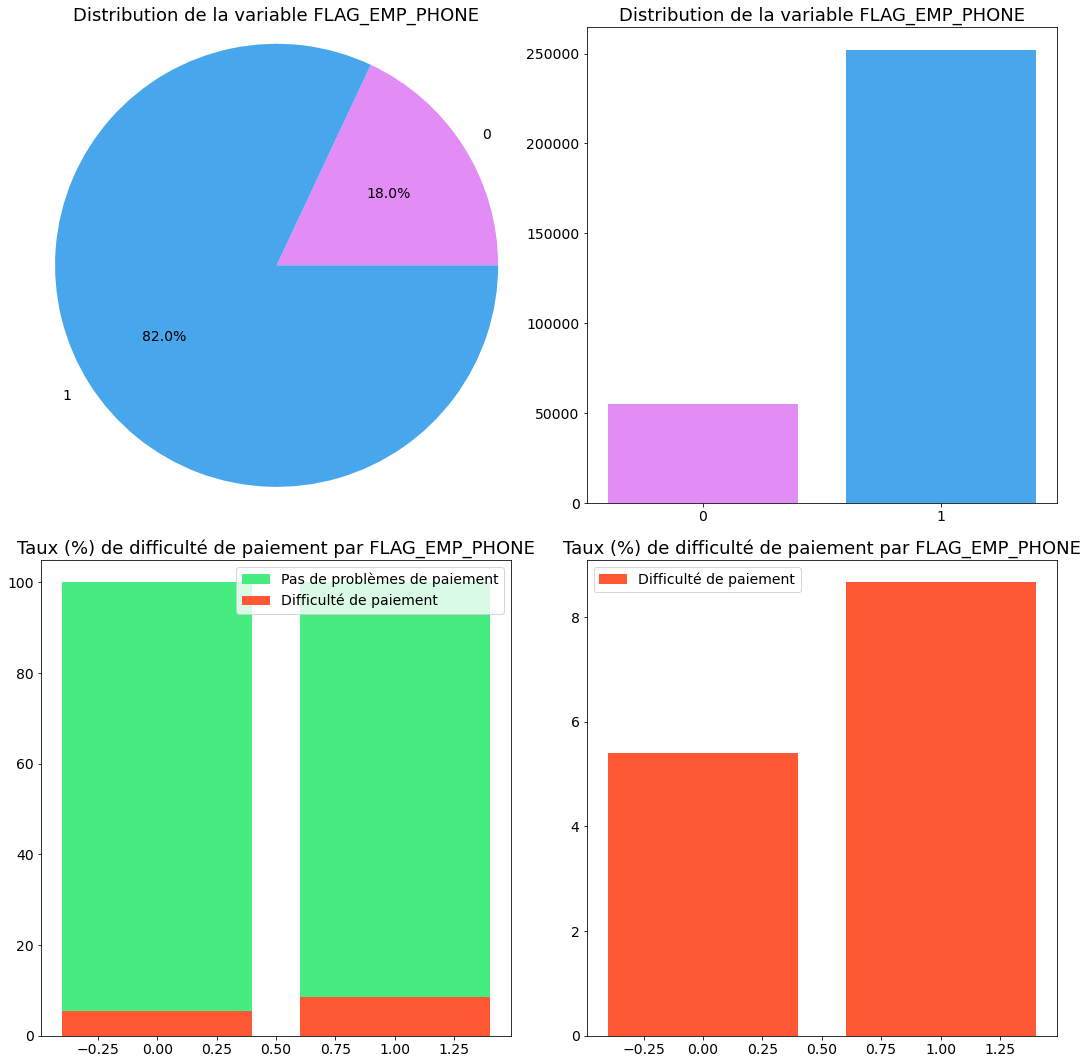

In [50]:
categ_var_plots(app_train, 'FLAG_EMP_PHONE')

Il y a une différence notable. Cette variable semble très importante. On pourrait penser que lorsqu'on fourni le n° de l'employeur, il y a plus de chance que le crédit soit remboursé.

**N° de tél personnel du travail fourni par le client**

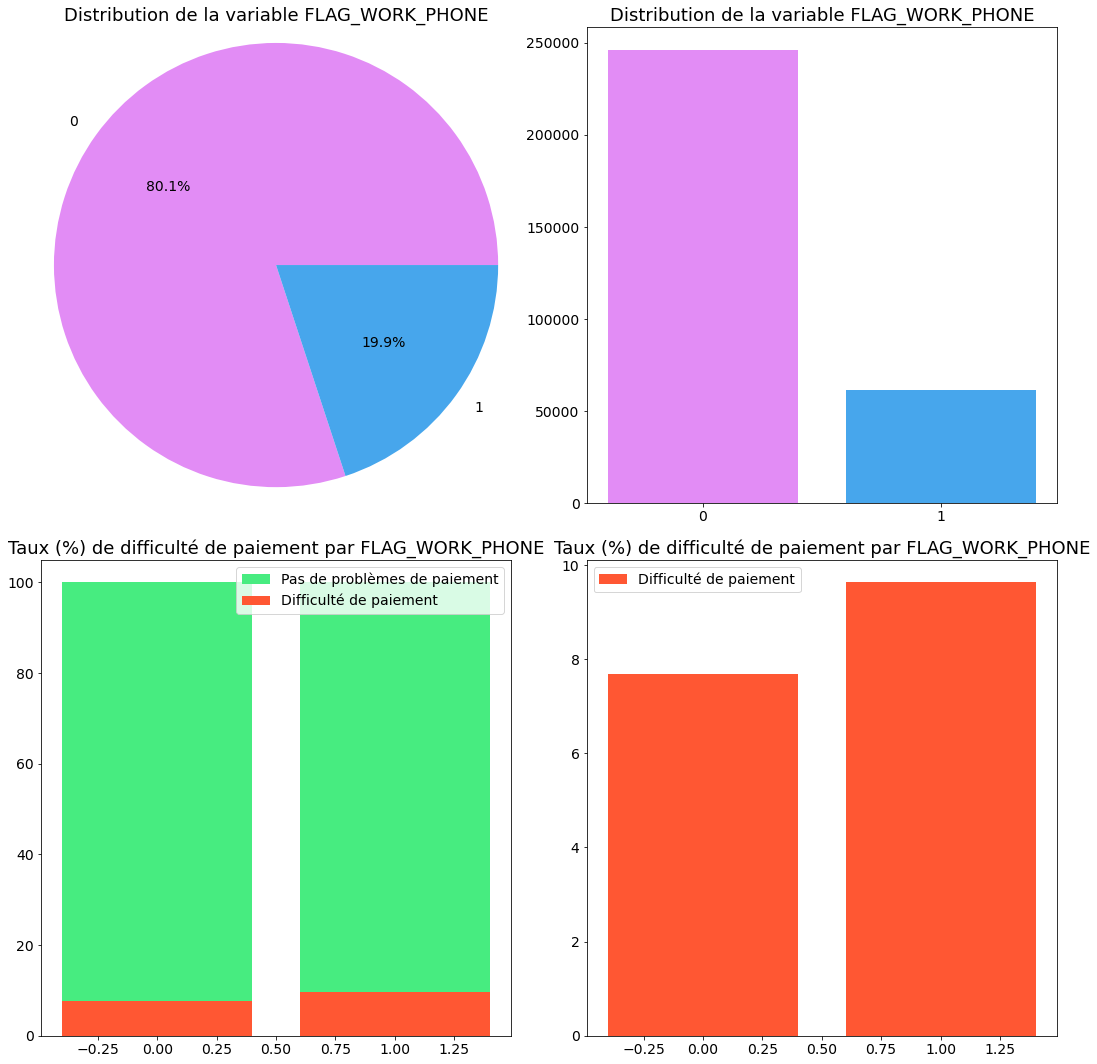

In [51]:
categ_var_plots(app_train, 'FLAG_WORK_PHONE')

**N° de tél mobile joignable**

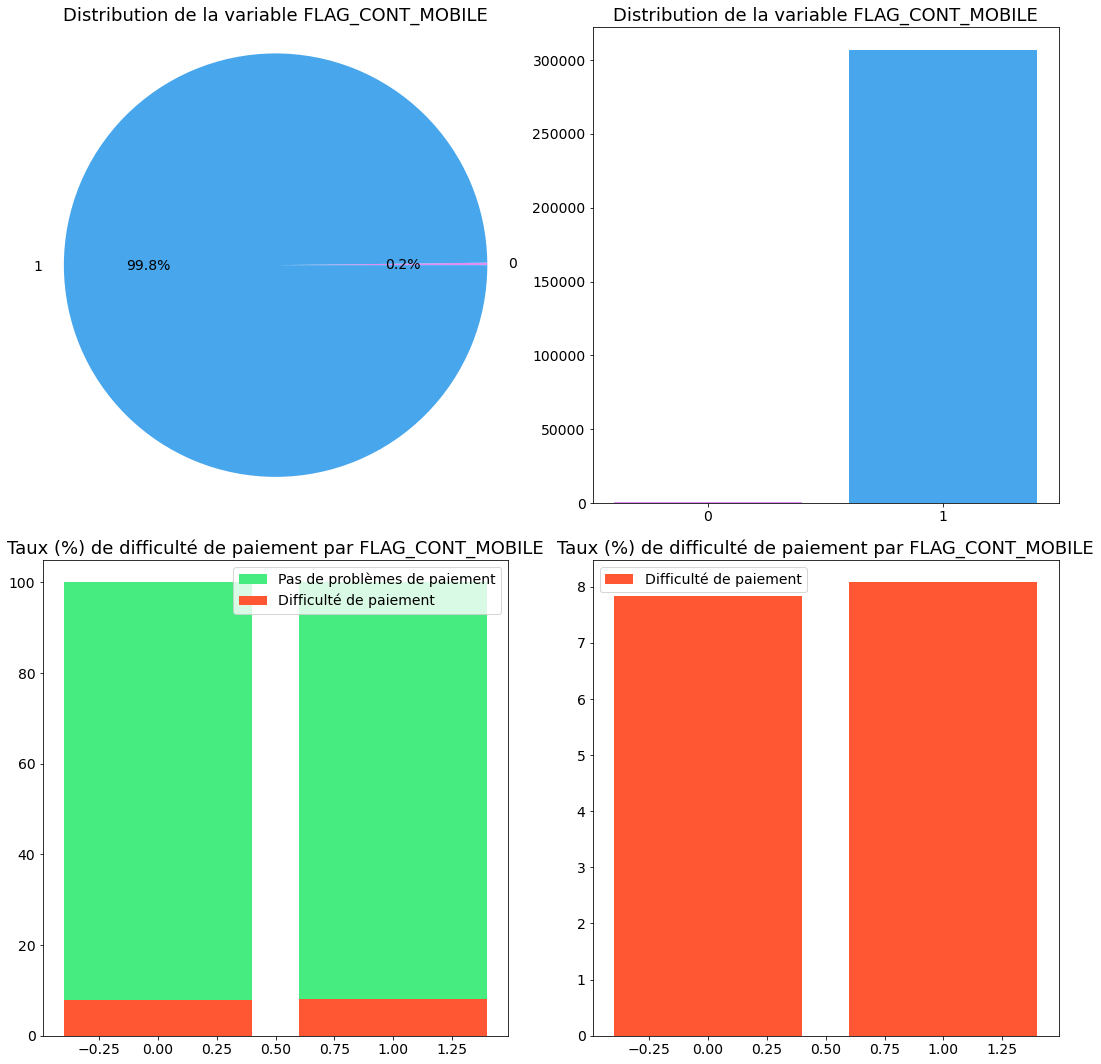

In [52]:
categ_var_plots(app_train, 'FLAG_CONT_MOBILE')

Pas de variance et peu d'influence. On supprime la variable.

In [53]:
app_train = app_train.drop('FLAG_CONT_MOBILE', axis=1)
app_test = app_test.drop('FLAG_CONT_MOBILE', axis=1)

**N° de tél fixe fourni**

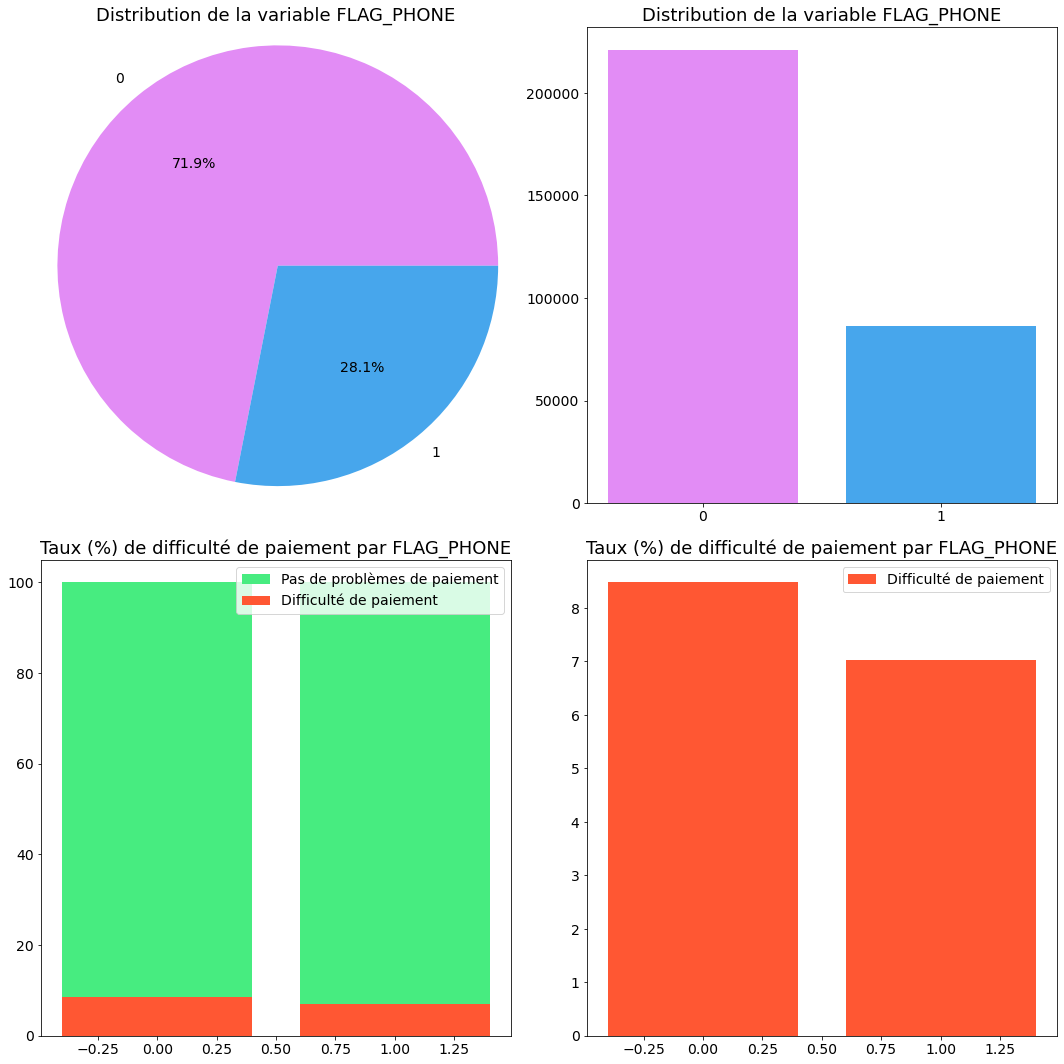

In [54]:
categ_var_plots(app_train, 'FLAG_PHONE')

**E-mail fourni**

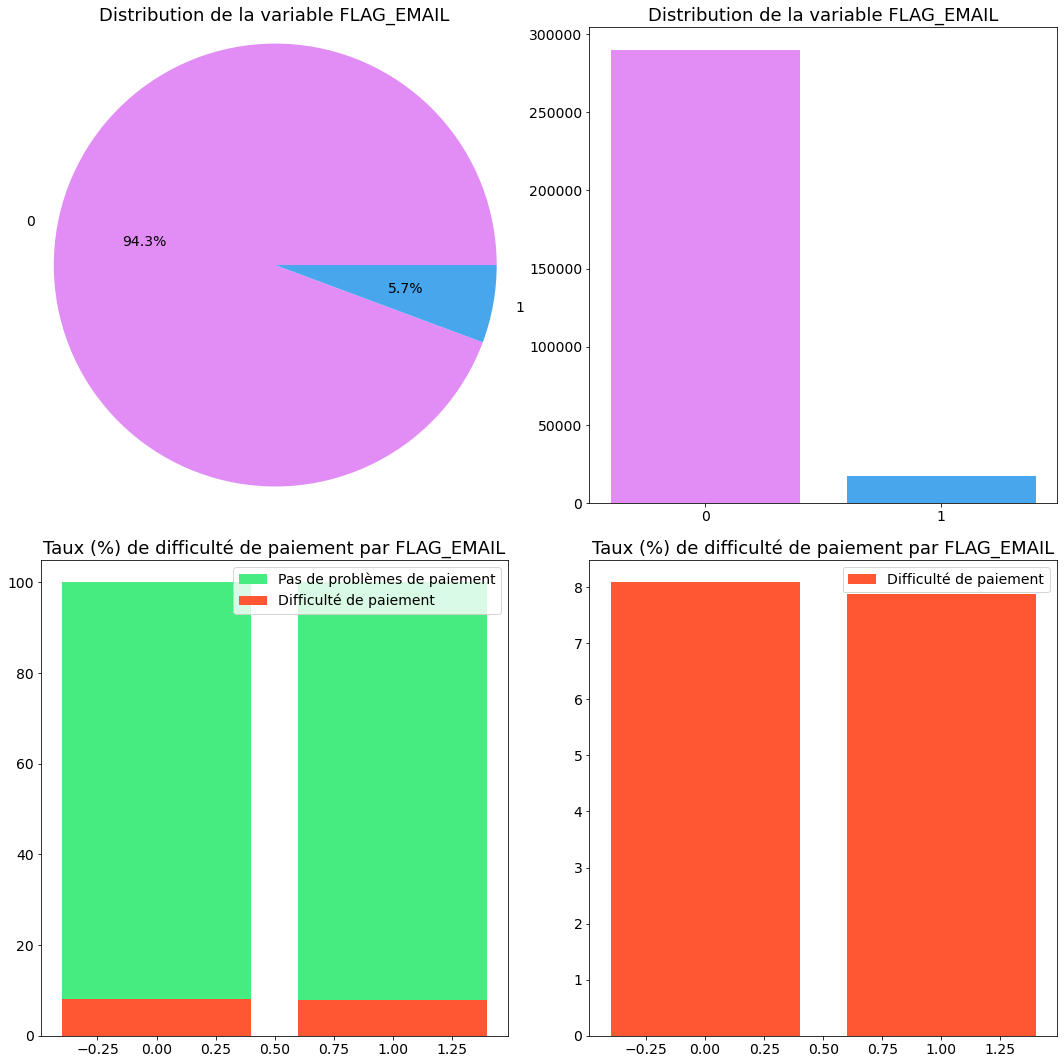

In [55]:
categ_var_plots(app_train, 'FLAG_EMAIL')

Cela ne semble pas avoir d'influence.

**Notation de la region dand laquelle le client vit**

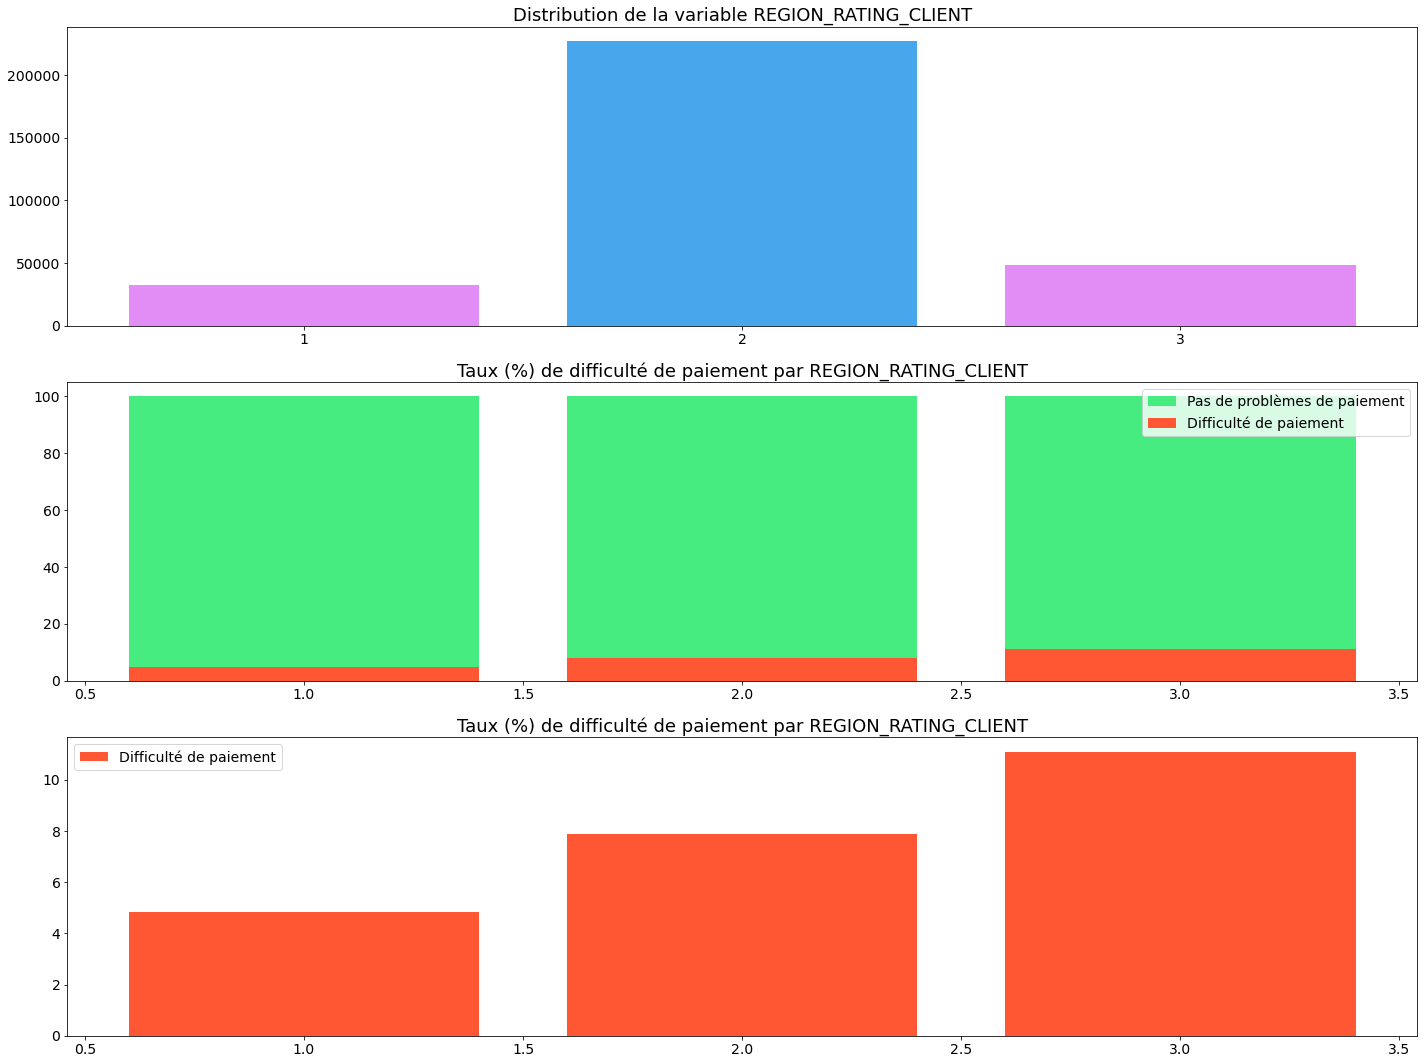

In [56]:
categ_var_plots(app_train, 'REGION_RATING_CLIENT')

Plus le score d'une region est haute, plus le potentiel de non-remboursabilité du client est élevé.

**Score de la region d'habitation du client en prenant en compte sa ville**

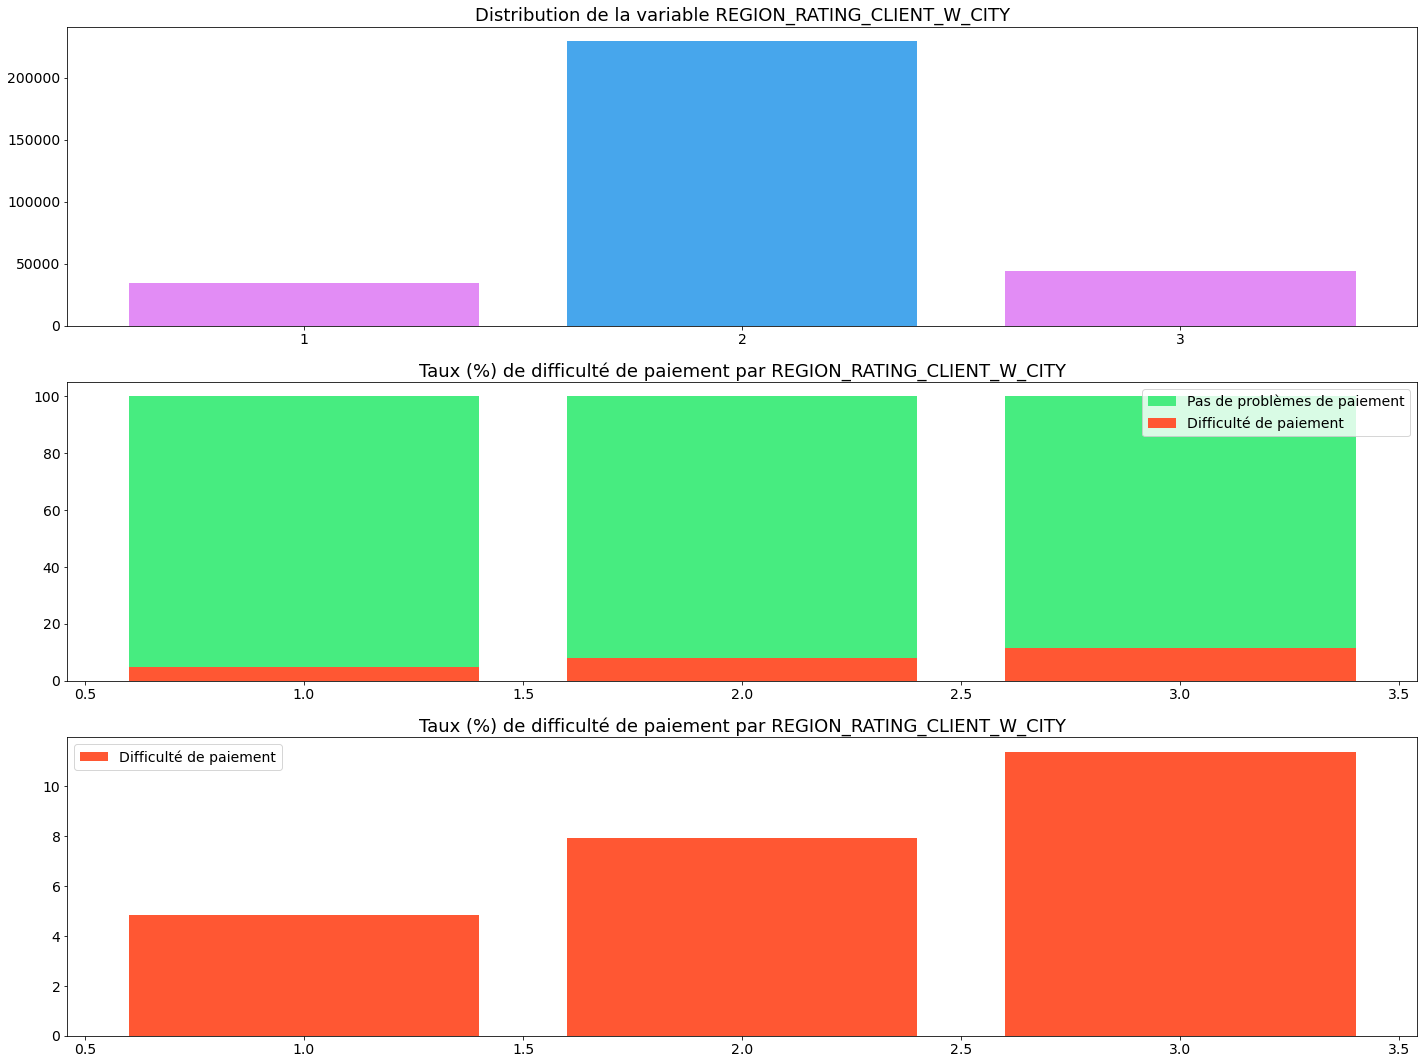

In [57]:
categ_var_plots(app_train, 'REGION_RATING_CLIENT_W_CITY')

On ne conservera que l'une des deux variables, pour éviter une redondance.

In [58]:
app_train = app_train.drop('REGION_RATING_CLIENT', axis=1)
app_test = app_test.drop('REGION_RATING_CLIENT', axis=1)

**Correspondance entre région de résidence et addresse de contact**

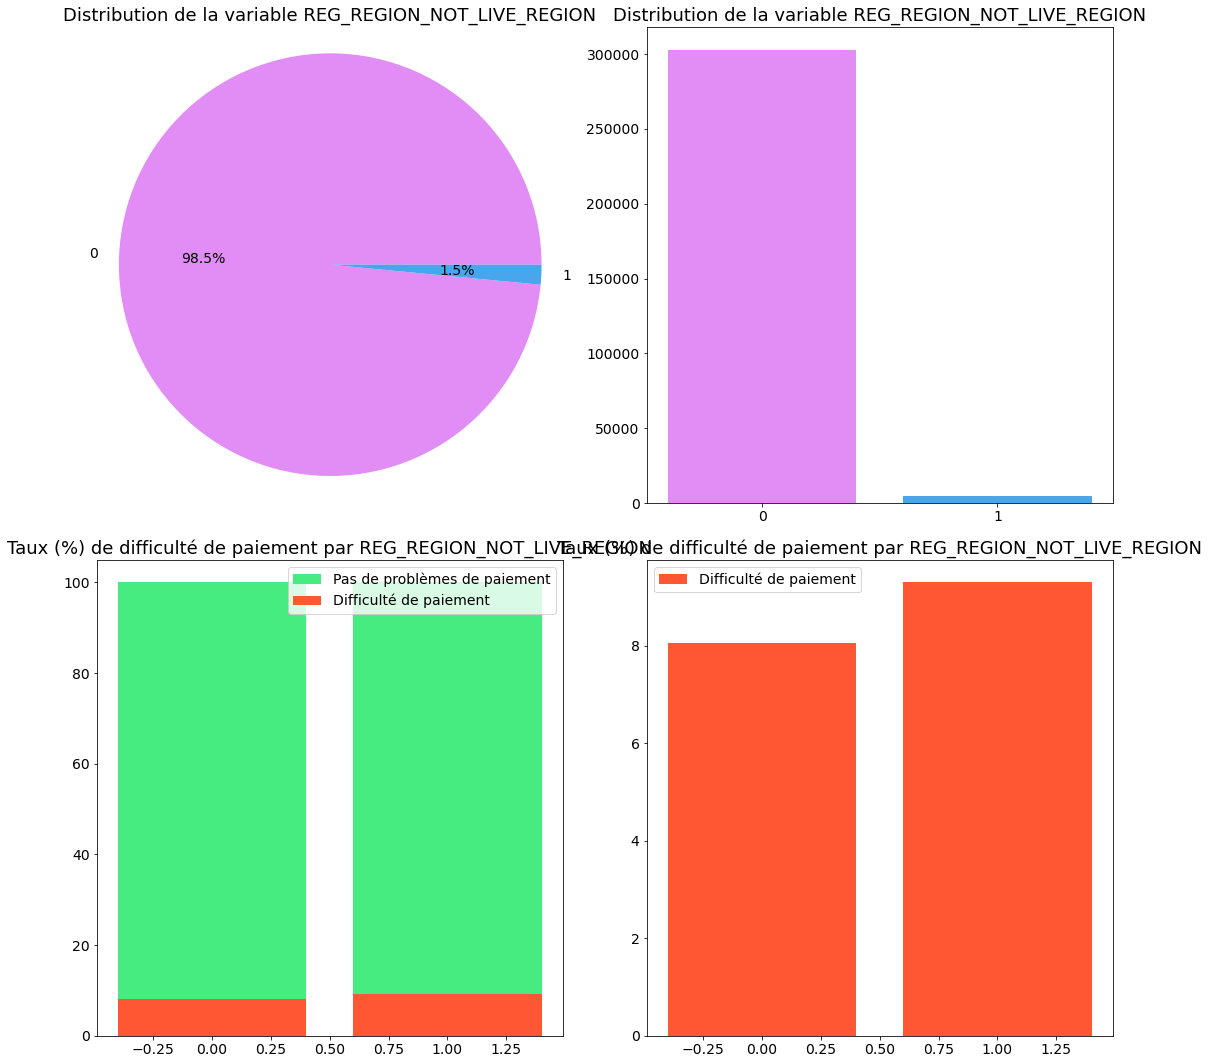

In [59]:
categ_var_plots(app_train, 'REG_REGION_NOT_LIVE_REGION')

**Correspondance entre région de résidence et lieu de travail**

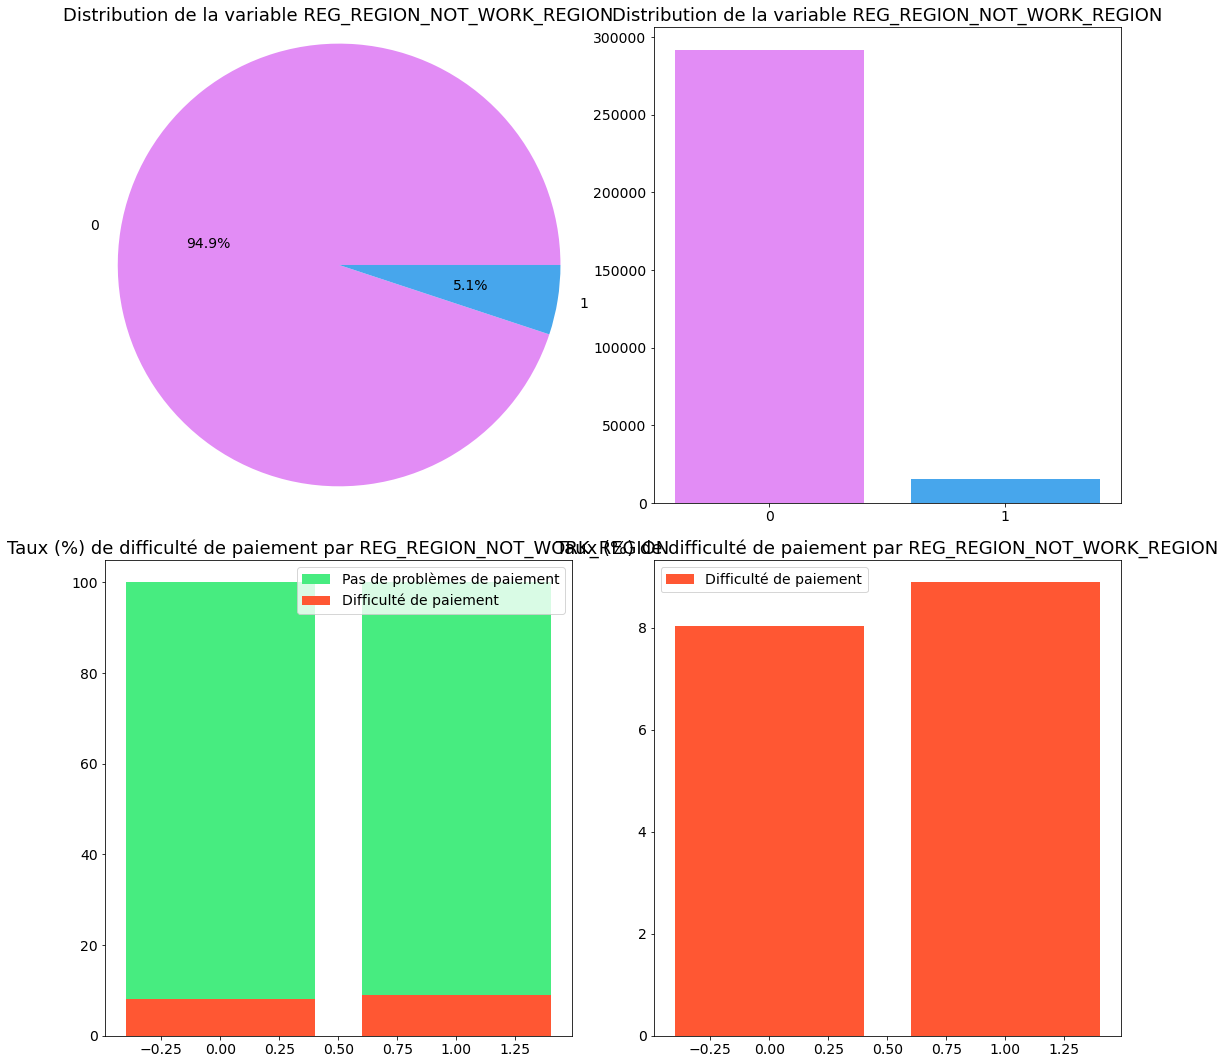

In [60]:
categ_var_plots(app_train, 'REG_REGION_NOT_WORK_REGION')

**Correspondance entre région de résidence et addresse de contact**

In [61]:
categ_var_plots(app_train, 'LIVE_REGION_NOT_WORK_REGION')

**Incohérence entre adresse fournie et adresse de contact**

In [62]:
categ_var_plots(app_train, 'REG_CITY_NOT_LIVE_CITY')

On observe une très grande différence. En général, un client présentant une incohérence entre son lieu de résidence et son lieu de contact est 1,5 fois plus suscpetible de ne pas rembourser son crédit.

In [63]:
categ_var_plots(app_train, 'REG_CITY_NOT_WORK_CITY')

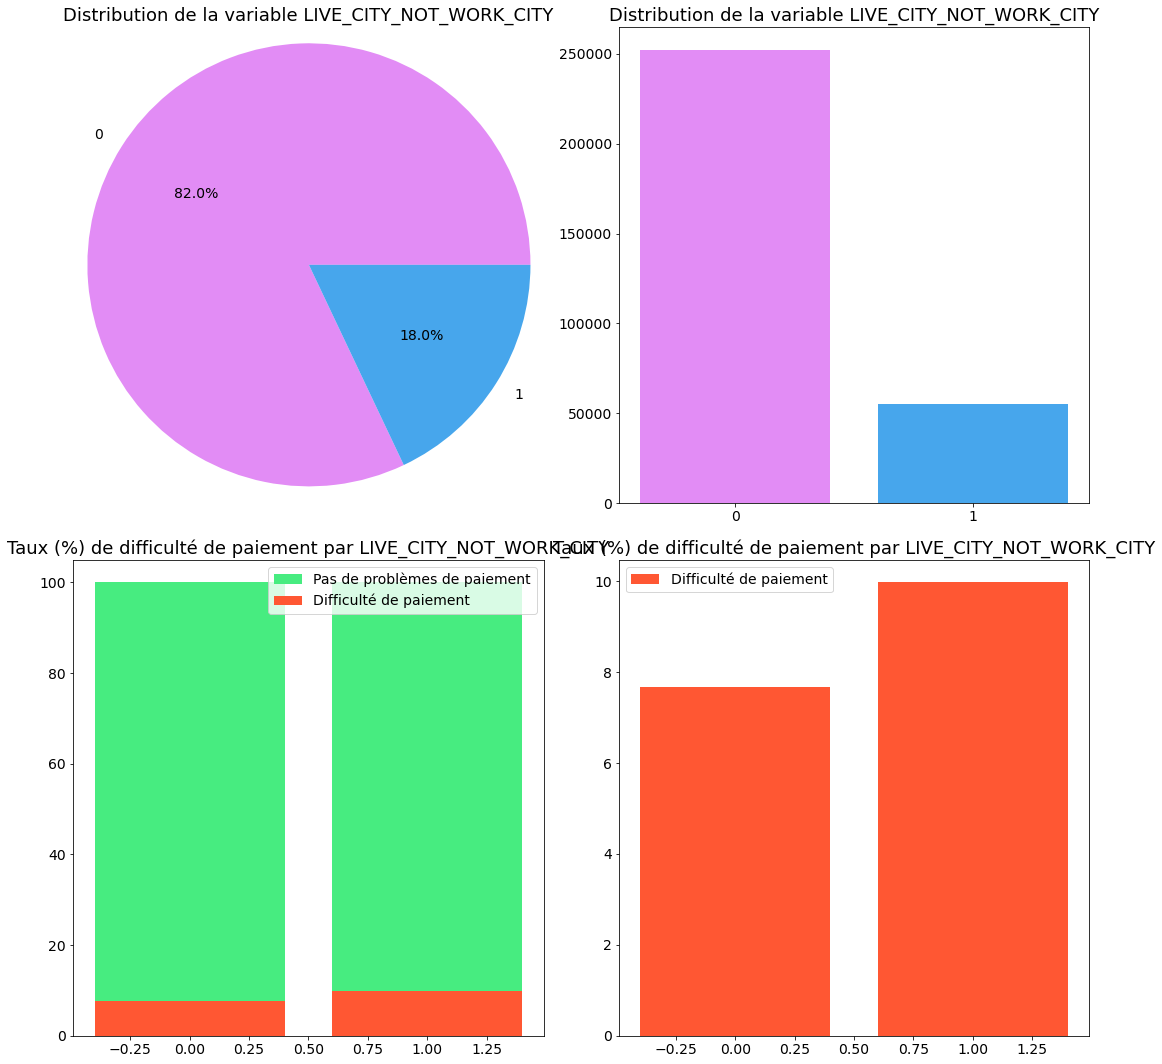

In [64]:
categ_var_plots(app_train, 'LIVE_CITY_NOT_WORK_CITY')

### <u>I.A.5 fonction d'affichage d'analyse des variables quantitatives

In [65]:
def plot_dist(df, var, title=None, bins=40):
    
    if title == None:
        title = var

    sns.set_style("whitegrid")
    plt.figure(figsize = (15, 8))
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var],
                label = 'Pas de difficultés de paiement', fill=True, color='blue')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var],
                label = 'Difficultés de paiement', fill=True, color='red')
    plt.xlabel(title)
    plt.ylabel('Densité')
    plt.title(f'Distribution de {title}')
    plt.legend()

In [66]:
def plot_bar_default(df, var, bins=np.array([]), n_bins=10):
    
    var_data = df[['TARGET', var]]
    min_var, max_var = round(df[var].min(),1), round(df[var].max(),1)
    bin_var = var+'_BINNED'
    
    if bins.any()==False:
        bins = np.linspace(min_var, max_var, num = n_bins)
    
    var_data['var_bin'] = pd.cut(var_data[var], bins = bins)
    var_groups  = var_data.groupby('var_bin').mean()
    
    plt.figure(figsize = (15, 8))
    plt.bar(var_groups.index.astype(str), 100 * var_groups['TARGET'], color='#FF5733')

    plt.xticks(rotation = 45)
    plt.xlabel(f'Groupe de {var}')
    plt.ylabel('Difficulté de paiement (%)')
    plt.title(f'Diffiulté de paiement par groupe de {var}');

### <u>I.A.6 Analyse descriptives des variables quantitatives

Voici le reste des variables (quantitatives)

In [67]:
num_features_tab[num_features_tab.values >= 5]

SK_ID_CURR                    307511
CNT_CHILDREN                      15
AMT_INCOME_TOTAL                2548
AMT_CREDIT                      5603
AMT_ANNUITY                    13672
AMT_GOODS_PRICE                 1002
REGION_POPULATION_RELATIVE        81
DAYS_BIRTH                     17460
DAYS_EMPLOYED                  12574
DAYS_REGISTRATION              15688
DAYS_ID_PUBLISH                 6168
CNT_FAM_MEMBERS                   17
HOUR_APPR_PROCESS_START           24
EXT_SOURCE_2                  119831
EXT_SOURCE_3                     814
OBS_30_CNT_SOCIAL_CIRCLE          33
DEF_30_CNT_SOCIAL_CIRCLE          10
OBS_60_CNT_SOCIAL_CIRCLE          33
DEF_60_CNT_SOCIAL_CIRCLE           9
DAYS_LAST_PHONE_CHANGE          3773
dtype: int64

**Nombre d'enfants**

In [68]:
plot_dist(app_train, 'CNT_CHILDREN')
plot_bar_default(app_train, 'CNT_CHILDREN', n_bins=20)

**Nombre de membres de la famille**

In [69]:
plot_dist(app_train, 'CNT_FAM_MEMBERS')
plot_bar_default(app_train, 'CNT_FAM_MEMBERS', n_bins=20)

Ces deux variables sont certainement extrêmement corrélées:

In [70]:
plt.scatter(app_train['CNT_FAM_MEMBERS'], app_train['CNT_CHILDREN'])
plt.show()

La seule différence possible est qu'il y ait un parent seul avec des enfants, ou deux parents avec des enfants.

Nous supprimerons une des deux variables, sachant que l'on dispose déjà d'un information sur la situtation familiale (marié ou pas etc).

In [71]:
app_train = app_train.drop('CNT_FAM_MEMBERS', axis=1)
app_test = app_test.drop('CNT_FAM_MEMBERS', axis=1)

**Revenu du client**

quelqueQ clients ont des revenus extremement élévés, ce sont des outliers.

In [72]:
app_train[app_train['AMT_INCOME_TOTAL']>1e6]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
1504        101769       0    Revolving loans           M            Y   
1723        102015       0         Cash loans           F            N   
3371        103938       0         Cash loans           F            N   
4603        105384       0    Revolving loans           F            Y   
7061        108224       0         Cash loans           F            Y   
...            ...     ...                ...         ...          ...   
298082      445335       0         Cash loans           M            Y   
300468      448102       0         Cash loans           F            N   
304477      452764       0         Cash loans           F            Y   
305577      454039       0         Cash loans           M            Y   
306028      454569       0    Revolving loans           M            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
1504                 Y             0         1080000.0    180000.0   
1723                 Y             0         1935000.0    269550.0   
3371                 N             1         1350000.0   2410380.0   
4603                 Y             0         1350000.0    405000.0   
7061                 N             0         1035000.0   2695500.0   
...                ...           ...               ...         ...   
298082               Y             0         2475000.0   1125000.0   
300468               Y             0         1575000.0   1223010.0   
304477               Y             1         2025000.0    935640.0   
305577               Y             0         1215000.0   1264738.5   
306028               Y             0         1350000.0   1575000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
1504         9000.0         180000.0   Unaccompanied  Commercial associate   
1723        10534.5         225000.0   Unaccompanied             Pensioner   
3371       109053.0        2250000.0           Other  Commercial associate   
4603        20250.0         405000.0   Unaccompanied  Commercial associate   
7061        74254.5        2250000.0   Unaccompanied  Commercial associate   
...             ...              ...             ...                   ...   
298082      47794.5        1125000.0   Unaccompanied               Working   
300468      51948.0        1125000.0          Family         State servant   
304477      93487.5         900000.0   Unaccompanied  Commercial associate   
305577      67513.5        1138500.0   Unaccompanied  Commercial associate   
306028      78750.0        1575000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
1504                 Higher education            Married  House / apartment   
1723    Secondary / secondary special            Married  House / apartment   
3371                 Higher education            Married  House / apartment   
4603                 Higher education            Married  House / apartment   
7061                 Higher education          Separated  House / apartment   
...                               ...                ...                ...   
298082  Secondary / secondary special            Married  House / apartment   
300468  Secondary / secondary special            Married  House / apartment   
304477               Higher education            Married  House / apartment   
305577               Higher education     Civil marriage  House / apartment   
306028               Higher education            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
1504                      0.072508      -13633          -5536   
1723                      0.007114      -18636         365243   
3371                      0.072508      -12213           -843   
4603                      0.018801      -14781          -4768   
7061                      0.046220      -10871           -490   
..

In [73]:
app_train = app_train[app_train['AMT_INCOME_TOTAL']<1e6]
app_test = app_test[app_test['AMT_INCOME_TOTAL']<1e6]

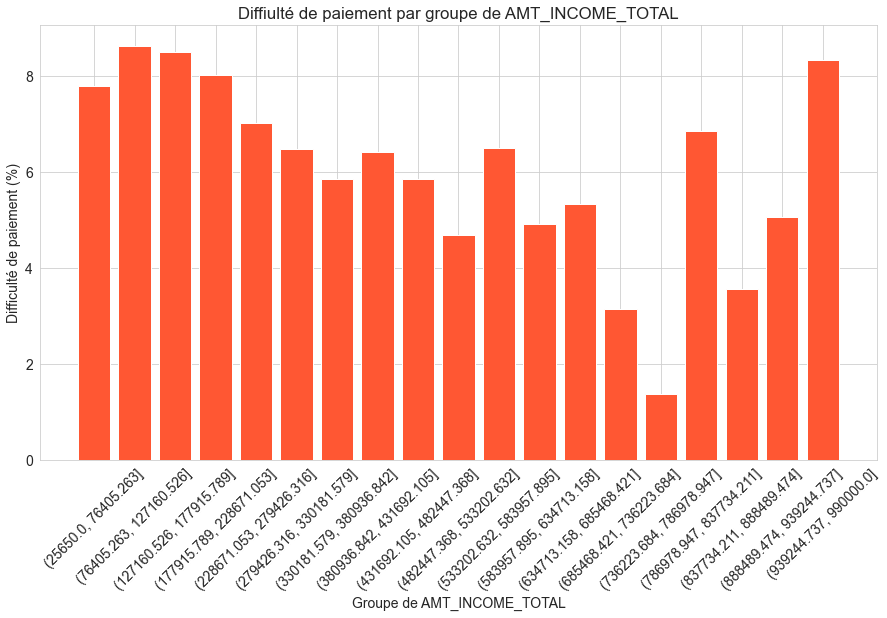

In [74]:
plot_dist(app_train, 'AMT_INCOME_TOTAL')
plot_bar_default(app_train, 'AMT_INCOME_TOTAL', n_bins=20)

**Somme empruntée**

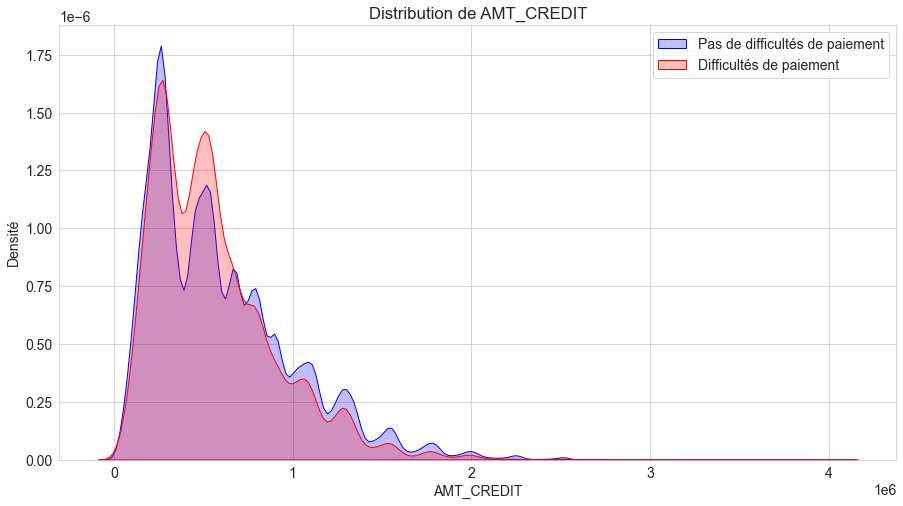

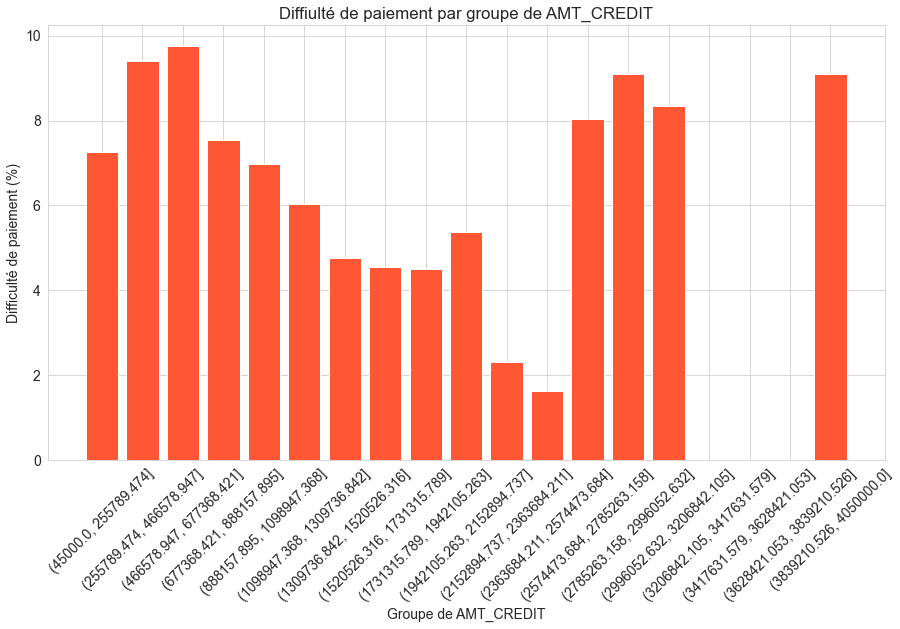

In [75]:
plot_dist(app_train, 'AMT_CREDIT')
plot_bar_default(app_train, 'AMT_CREDIT', n_bins=20)

**Mensualité du prêt**

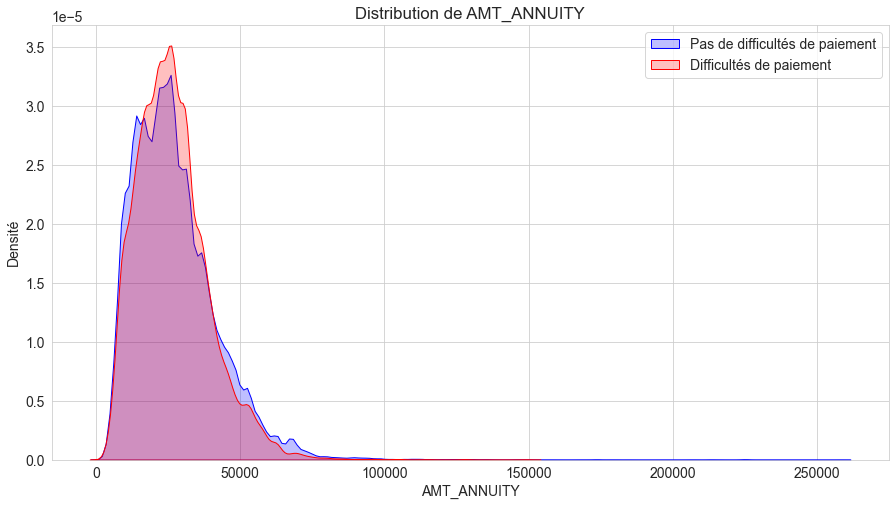

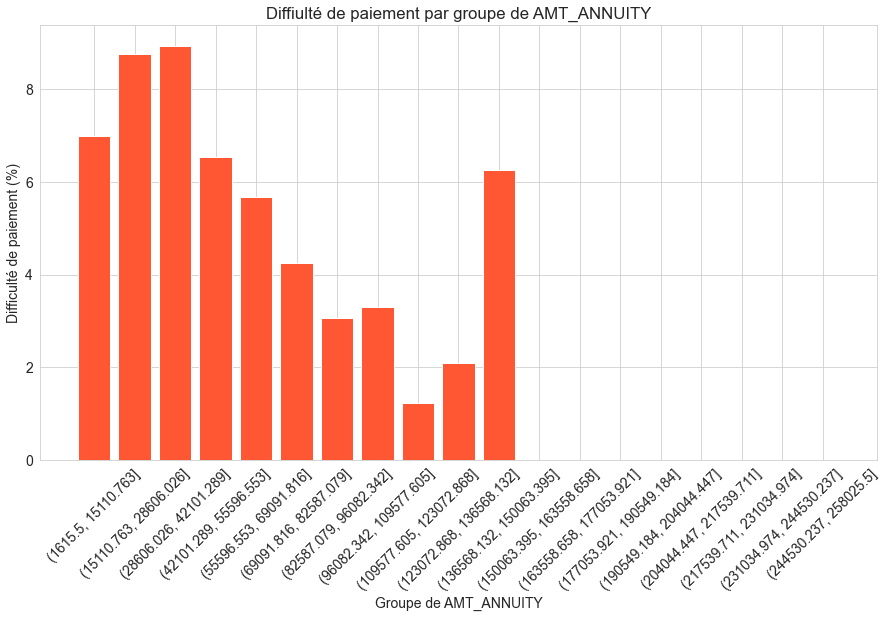

In [76]:
plot_dist(app_train, 'AMT_ANNUITY')
plot_bar_default(app_train, 'AMT_ANNUITY', n_bins=20)

**Prix des biens pour lequel le prêt est accordé**

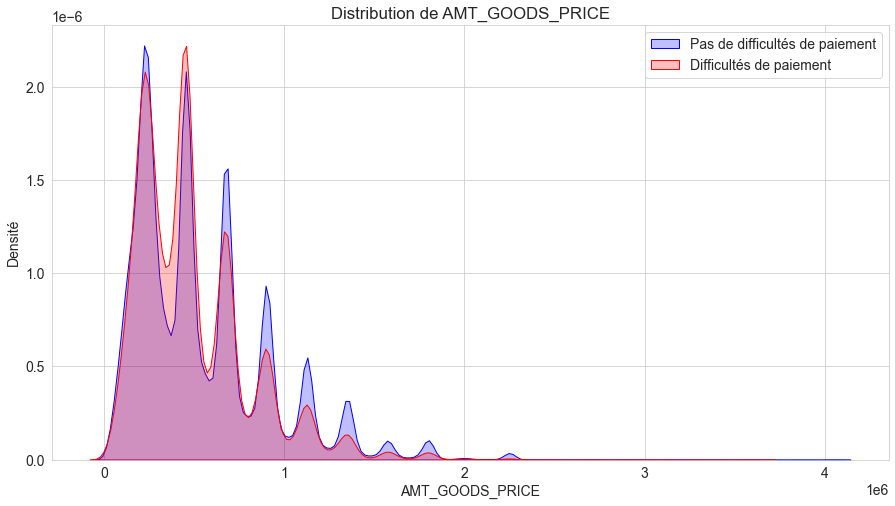

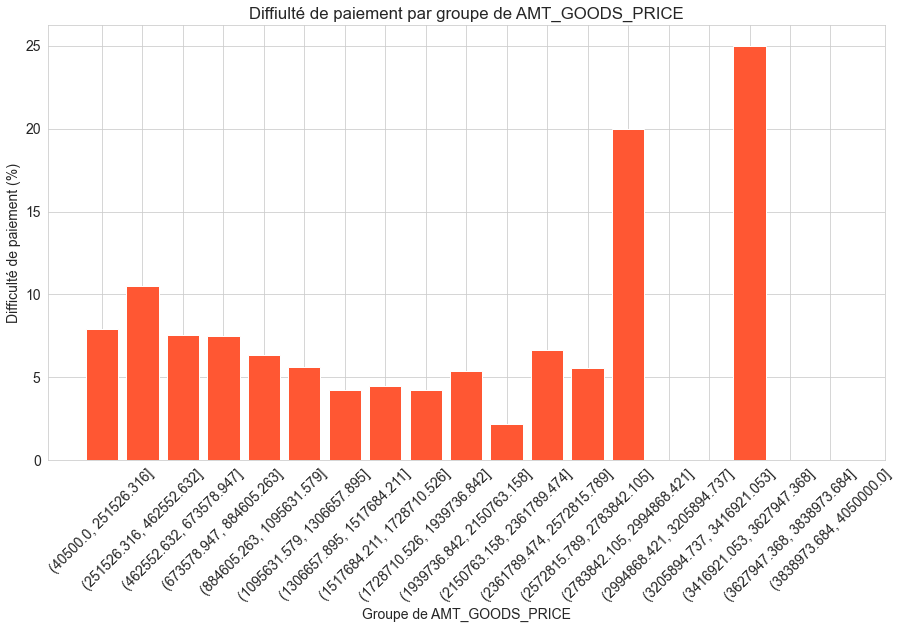

In [77]:
plot_dist(app_train, 'AMT_GOODS_PRICE')
plot_bar_default(app_train, 'AMT_GOODS_PRICE', n_bins=20)

**Population normalisée de de la région dans laquelle le client vit.**

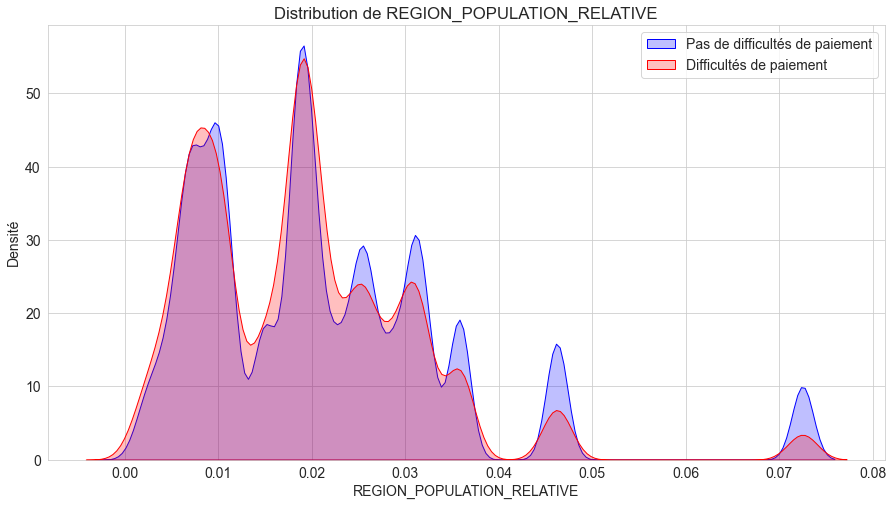

In [78]:
plot_dist(app_train, 'REGION_POPULATION_RELATIVE')
plot_bar_default(app_train, 'REGION_POPULATION_RELATIVE', n_bins=11)

Pour les régions ayant une forte population, il y a une différence de capcité de paiement.

**AGE**

In [79]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])/365
app_train = app_train.rename(columns={'DAYS_BIRTH':'Age'})
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])/365
app_test = app_train.rename(columns={'DAYS_BIRTH':'Age'})

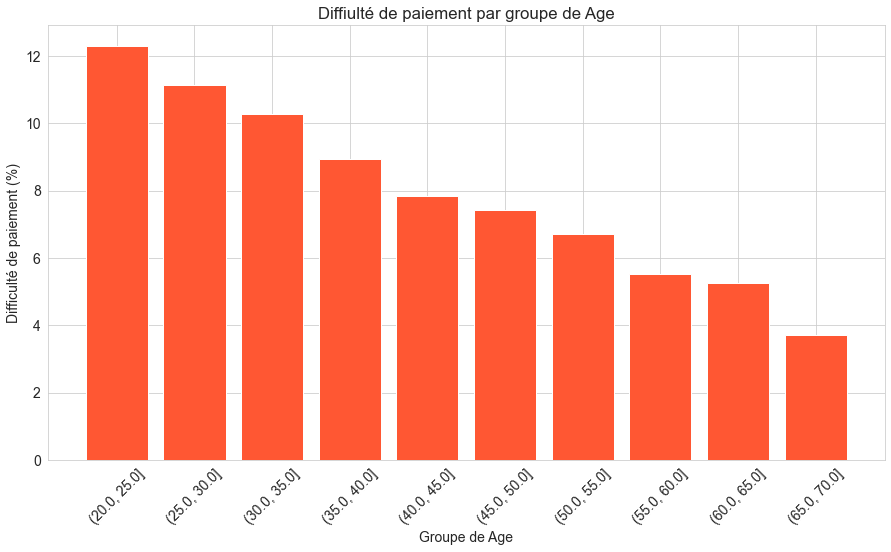

In [80]:
plot_dist(app_train, 'Age', title='Age')
plot_bar_default(app_train, 'Age', bins=np.linspace(20,80, 13))

L'age semble avoir une influence nette sur la capacité à rembourser ou non le prêt.
Plus l'emprunteur est jeune, plus il sera probable qu'il ait des difficultés à rembourser son prêt.

**Jours de travail**

In [81]:
# Il y a une anomalie: quelques miliers ont exactement un nombre exagéré de jours de travail:
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])

app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED'] = abs(app_test['DAYS_EMPLOYED'])

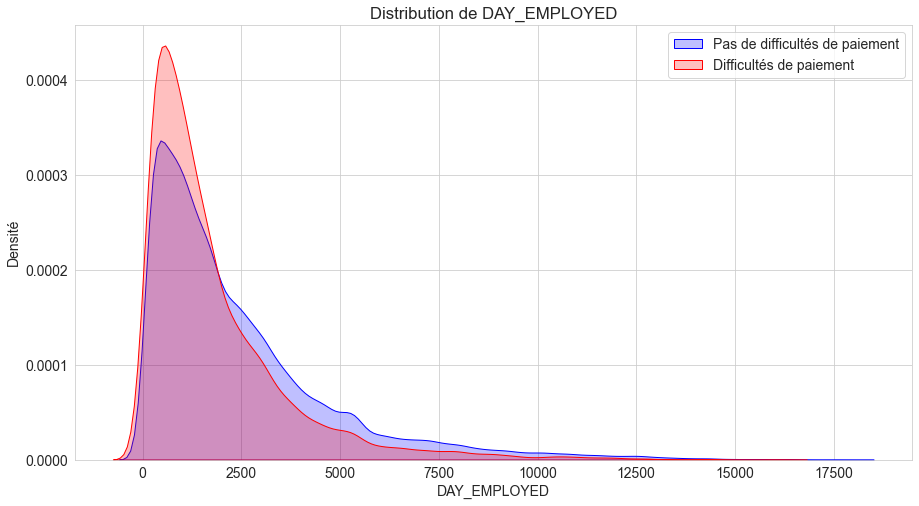

In [82]:
plot_dist(app_train, 'DAYS_EMPLOYED', title='DAY_EMPLOYED')
plot_bar_default(app_train, 'DAYS_EMPLOYED', bins=np.linspace(0,18000, 19))

On observe des anomalies sur les jours d'emploi pour 18%.
Il semble qu ces anomalies soient en fait dues au manque d'informations, en prenant une valeur automatique de 365243.
Le défaut de paiement de ces indicidus à anomalie est d'environ 5%, ce qui correspond au défaut de paiement d'un client ayant 4500 jours de travail. graphique ci-dessus. On imputera donc par 4500 ces anomalies.

In [83]:
categ_var_plots(app_train, 'DAYS_EMPLOYED_ANOM')

In [84]:
app_train['DAYS_EMPLOYED'].replace({np.nan:4500}, inplace = True)
app_test['DAYS_EMPLOYED'].replace({np.nan:4500}, inplace = True)

In [85]:
app_train = app_train.drop('DAYS_EMPLOYED_ANOM', axis=1)
app_test = app_test.drop('DAYS_EMPLOYED_ANOM', axis=1)

**Temps avant la demande de prêt où le client à changer ses informations d'enregistrement**

In [86]:
app_train['DAYS_REGISTRATION'] = np.abs(app_train['DAYS_REGISTRATION'])
app_test['DAYS_REGISTRATION'] = np.abs(app_test['DAYS_REGISTRATION'])

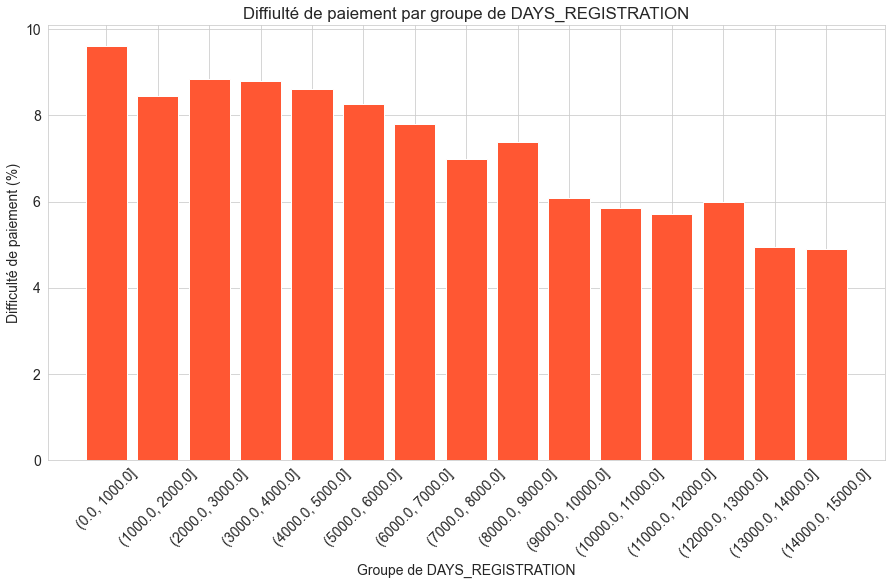

In [87]:
plot_dist(app_train, 'DAYS_REGISTRATION', title='DAY_REGISTRATION')
plot_bar_default(app_train, 'DAYS_REGISTRATION', bins=np.linspace(0, 15000,16))

Il semble y avoir une faible influence de cette variable. Au plus tard le client change son enregistrement, au plus il a tendance à présenter des difficultés de paiements des son crédit.

**Temps avant la demande de prêt où le client à changer ses information d'identité**

In [88]:
app_train['DAYS_ID_PUBLISH'] = np.abs(app_train['DAYS_ID_PUBLISH'])
app_test['DAYS_ID_PUBLISH'] = np.abs(app_test['DAYS_ID_PUBLISH'])
plot_dist(app_train, 'DAYS_ID_PUBLISH', title='DAYS_ID_PUBLISH')
plot_bar_default(app_train, 'DAYS_ID_PUBLISH', bins=np.linspace(0, 15000,16))

De façon similaire à la variables précédente: le temps de changement d'indentité à une influence. DAYS_ID_PUBLISH et DAY_REGISTRATION doivent certainement être corrélées. Nous verrons cela dans la partie suivante.

**Heure du début du processus**

In [89]:
plot_dist(app_train, 'HOUR_APPR_PROCESS_START', title='HOUR_APPR_PROCESS_START')
plot_bar_default(app_train, 'HOUR_APPR_PROCESS_START', n_bins=24)

**Jours de changement de numéro de téléphone**

In [90]:
app_train['DAYS_LAST_PHONE_CHANGE'] = np.abs(app_train['DAYS_LAST_PHONE_CHANGE'])
app_test['DAYS_LAST_PHONE_CHANGE'] = np.abs(app_test['DAYS_LAST_PHONE_CHANGE'])
plot_dist(app_train, 'DAYS_LAST_PHONE_CHANGE', title='DAYS_LAST_PHONE_CHANGE')
plot_bar_default(app_train, 'DAYS_LAST_PHONE_CHANGE', bins=np.linspace(-1000, 4000, 6))

**Nombre d'observations de l'environnement social du client avec des défauts observables de 30 DPD (jours de retard)**

Il y a des valeurs abberantes. Nous supprimerons les individus présentant ces valeurs aberrantes.

In [91]:
app_train = app_train[app_train['OBS_30_CNT_SOCIAL_CIRCLE']<20]
app_test = app_test[app_test['OBS_30_CNT_SOCIAL_CIRCLE']<20]

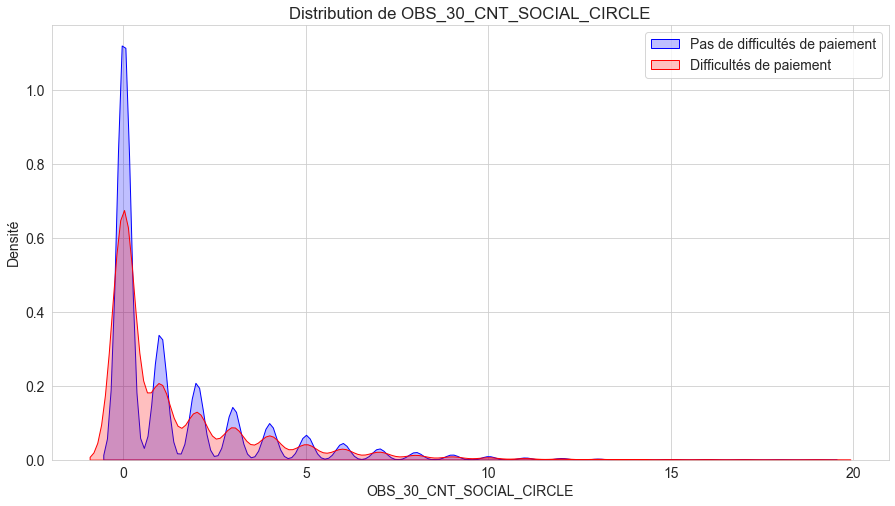

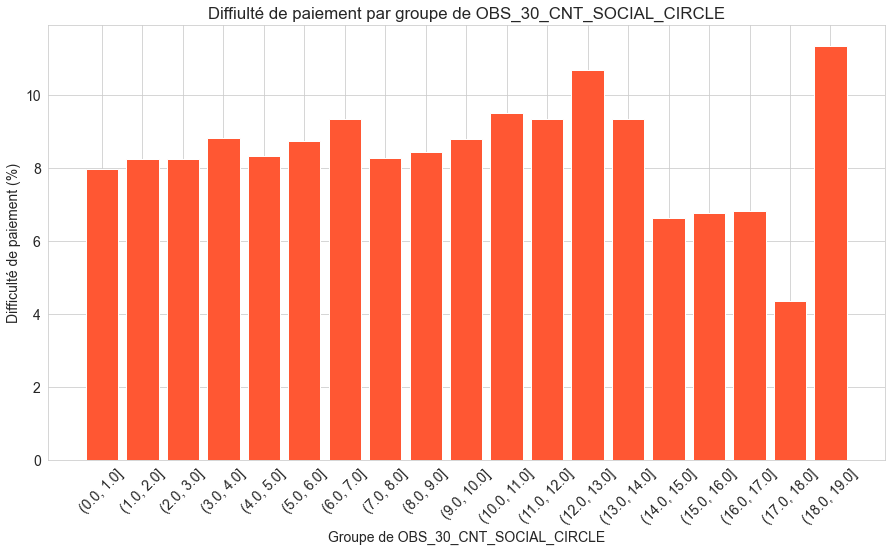

In [92]:
plot_dist(app_train, 'OBS_30_CNT_SOCIAL_CIRCLE', title='OBS_30_CNT_SOCIAL_CIRCLE')
plot_bar_default(app_train, 'OBS_30_CNT_SOCIAL_CIRCLE', n_bins=20)

Cela ne semble pas avoir beaucoup d'importance.

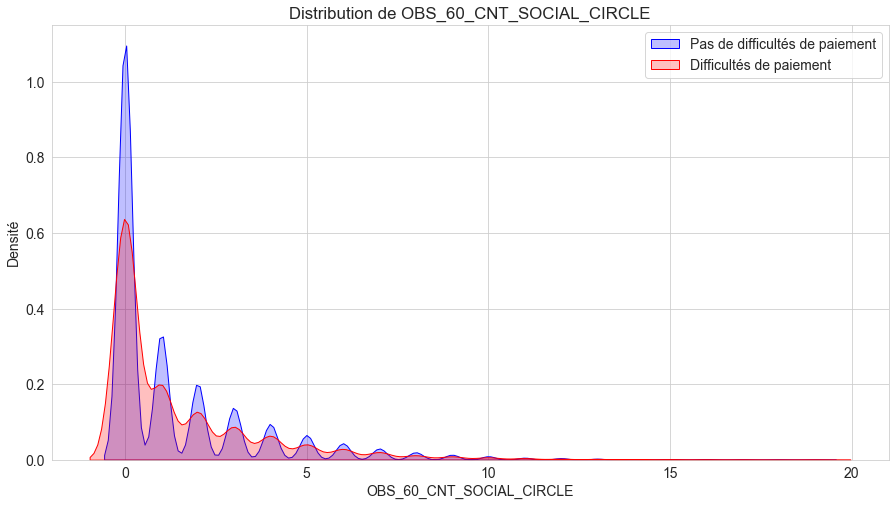

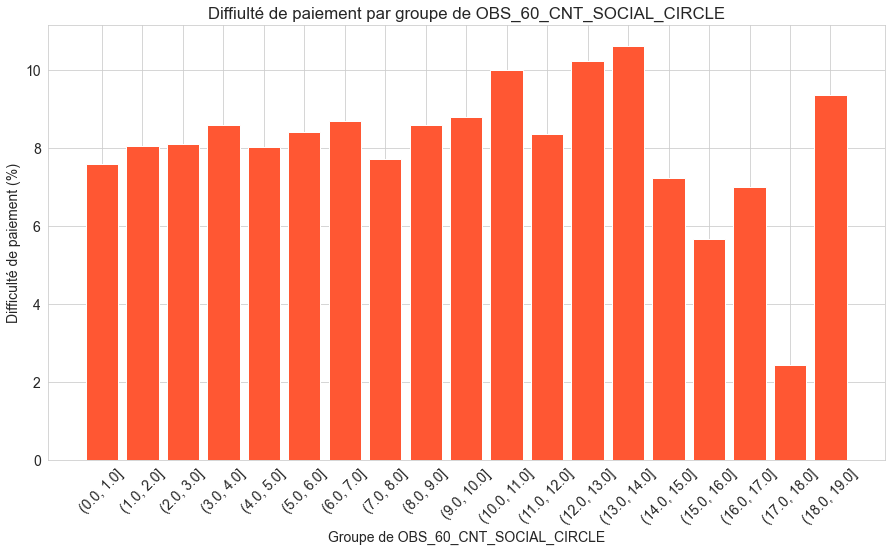

In [103]:
plot_dist(app_train, 'OBS_60_CNT_SOCIAL_CIRCLE', title='OBS_60_CNT_SOCIAL_CIRCLE')
plot_bar_default(app_train, 'OBS_60_CNT_SOCIAL_CIRCLE', n_bins=20)

Il en est de même pour 60 jours de retard.

**Nombre d'observations de l'environnement social du client avec des défauts de 30 ou 60 DPD (jours de retard)**

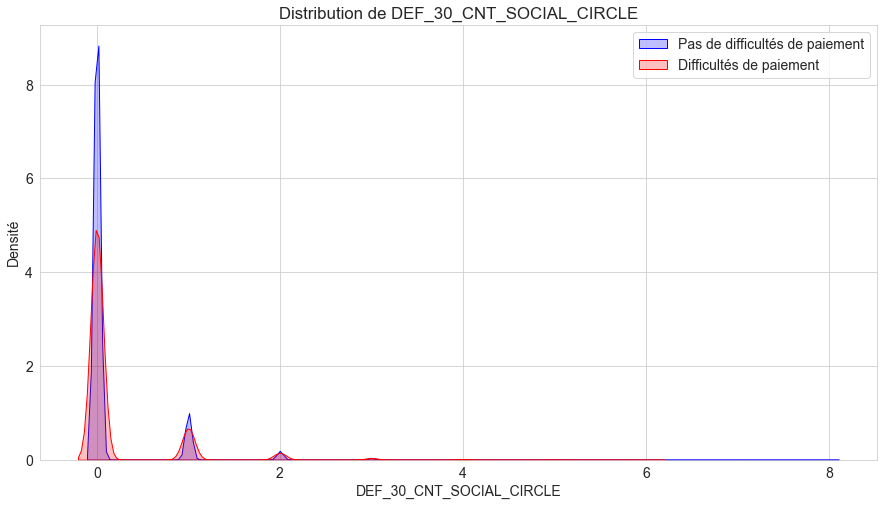

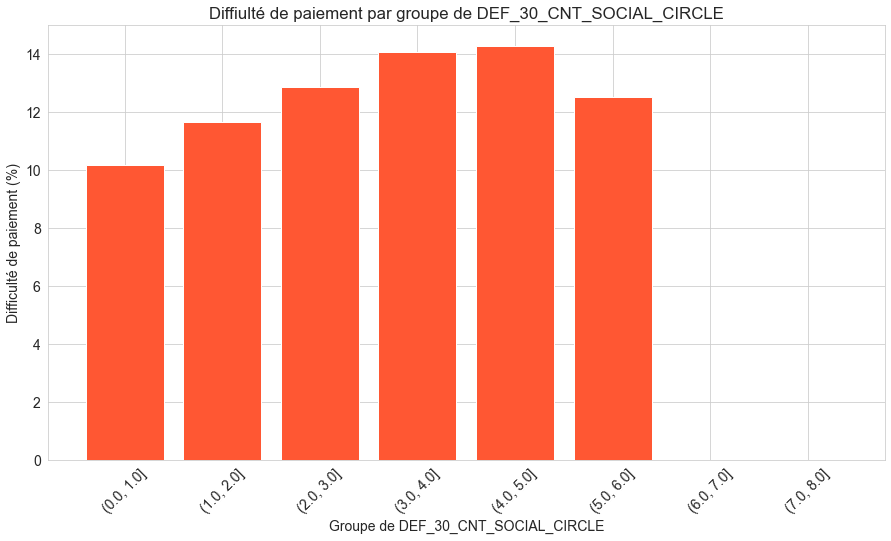

In [94]:
plot_dist(app_train, 'DEF_30_CNT_SOCIAL_CIRCLE', title='DEF_30_CNT_SOCIAL_CIRCLE')
plot_bar_default(app_train, 'DEF_30_CNT_SOCIAL_CIRCLE', n_bins=9)

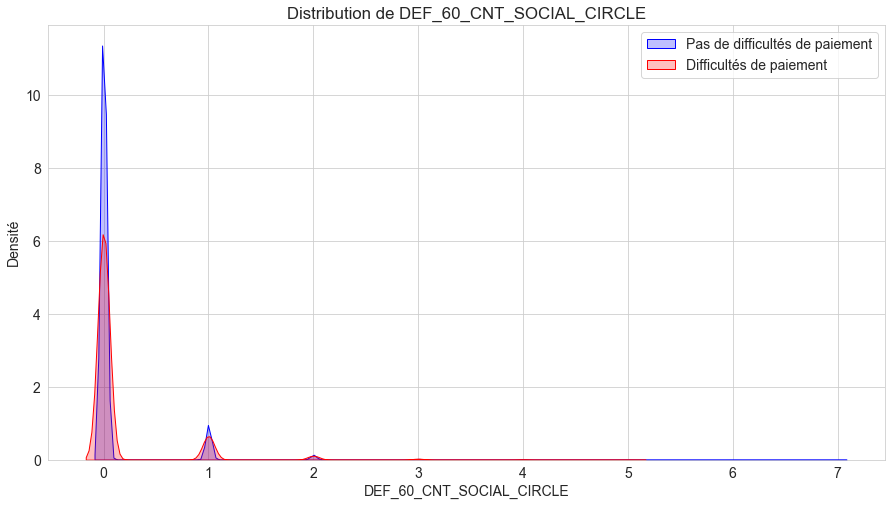

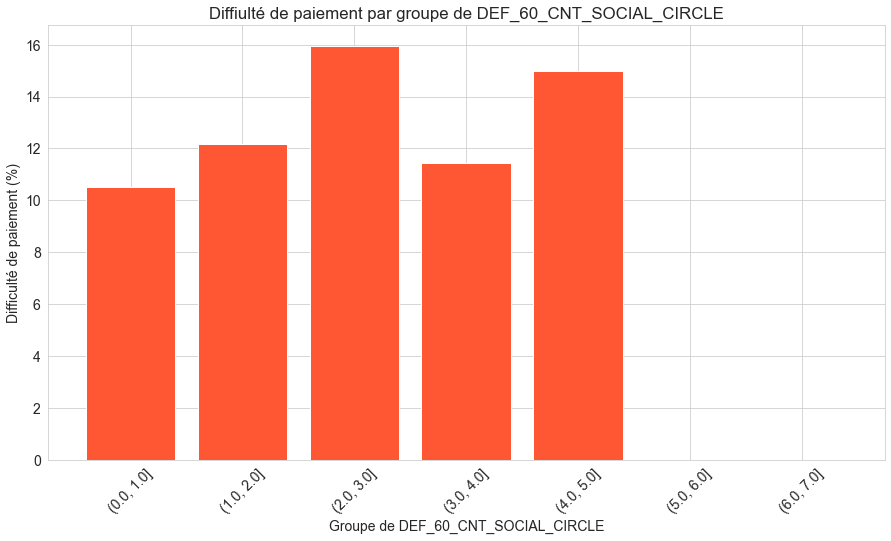

In [95]:
plot_dist(app_train, 'DEF_60_CNT_SOCIAL_CIRCLE', title='DEF_60_CNT_SOCIAL_CIRCLE')
plot_bar_default(app_train, 'DEF_60_CNT_SOCIAL_CIRCLE', n_bins=8)

**EXT SOURCE 2 et EXT_SOURCE_3 sont des données extérieures normalisées. Il est difficile d'interpréter ces valeurs, cependant nous pouvons observer qu'elle jouent un rôle très important dans la capacité d'un client à rembourser sont prêt**

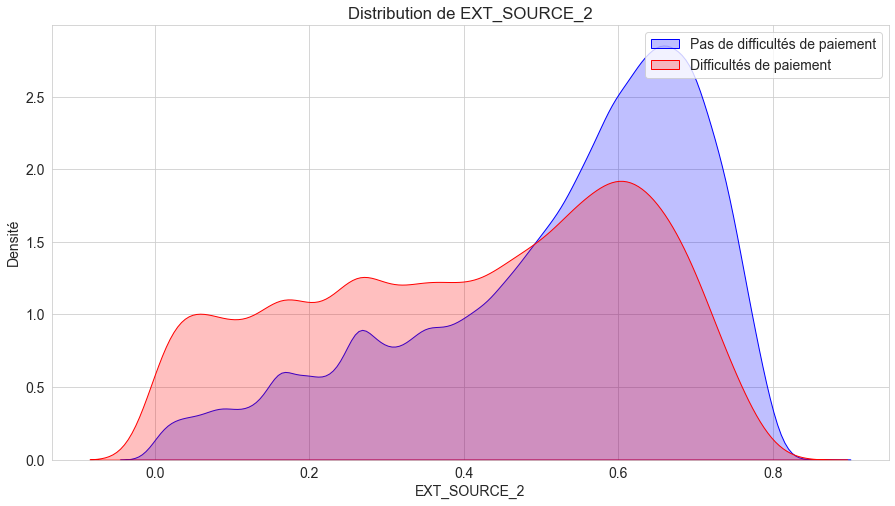

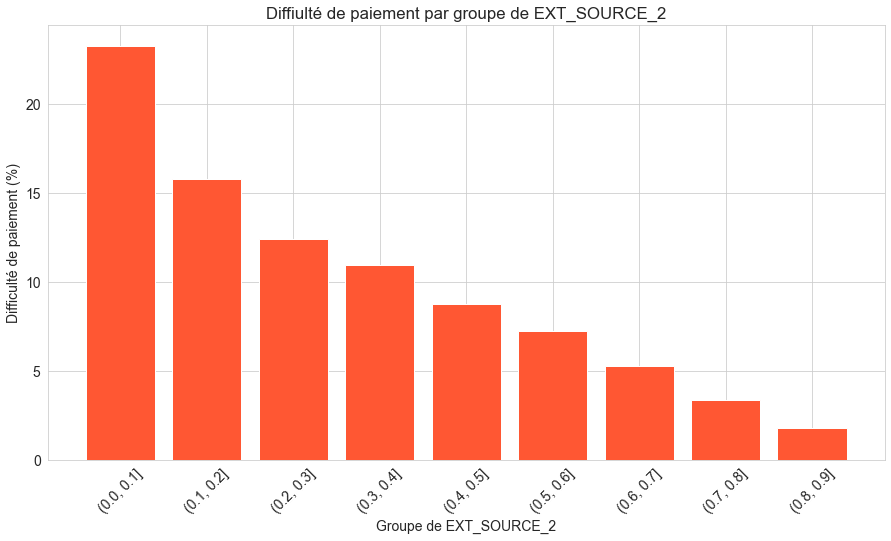

In [96]:
plot_dist(app_train, 'EXT_SOURCE_2', title='EXT_SOURCE_2')
plot_bar_default(app_train, 'EXT_SOURCE_2', n_bins=10)

Il faudra donc essayer de déterminer avec quelles variables sont corrélées EXT_SOURCE_2 et EXT_SOURCE_3.

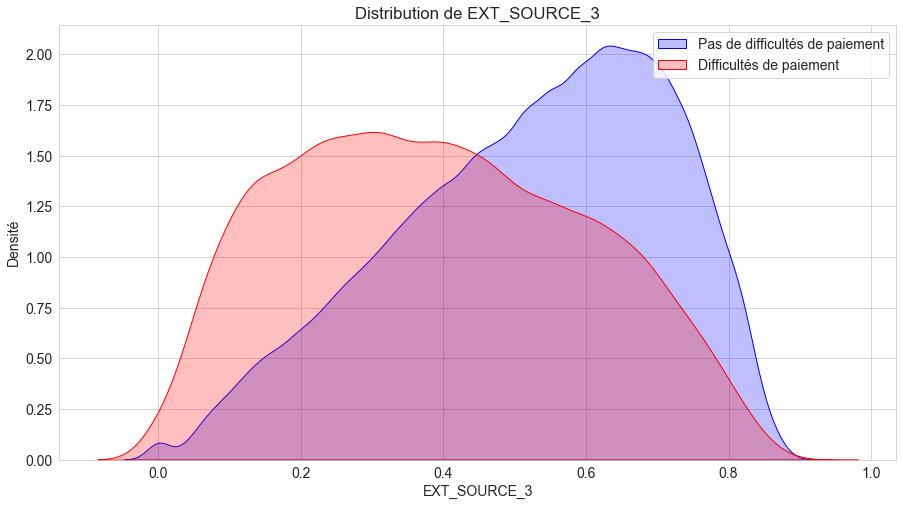

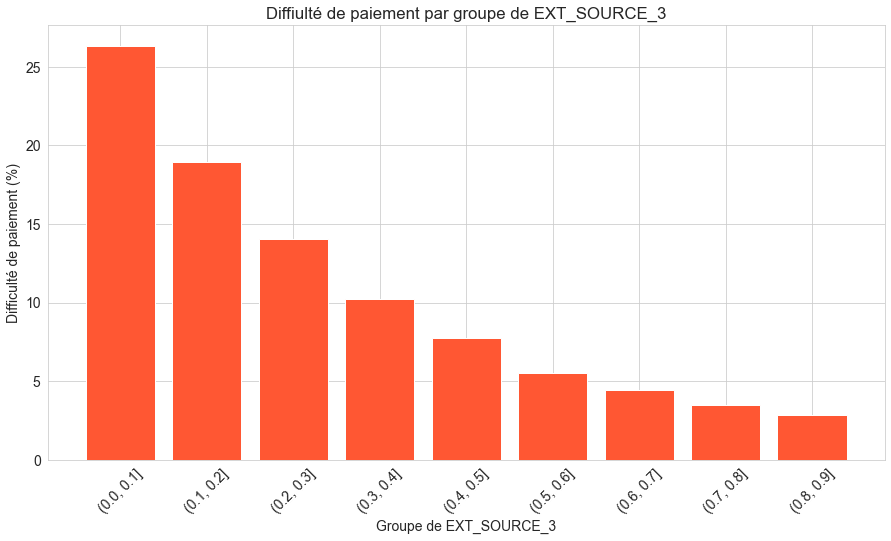

In [102]:
plot_dist(app_train, 'EXT_SOURCE_3', title='EXT_SOURCE_3')
plot_bar_default(app_train, 'EXT_SOURCE_3', n_bins=10)

In [99]:
app_train = app_train.dropna()
app_test = app_test.dropna()

## <u>I.B. Exploration de la table bureau

In [104]:
bureau = pd.read_csv("bureau.csv")
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

## <u>I.C. Exploration de la table bureau balance

In [105]:
bureau_balance = pd.read_csv("bureau_balance.csv")
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

## <u>I.D. Exploration de la table Crédit Card Balance

In [106]:
credit_card_balance = pd.read_csv("credit_card_balance.csv")
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

## <u>I.E. Exploration de la table POS_CASH

In [107]:
pcb = pd.read_csv("POS_CASH_balance.csv")
pcb.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

## <u>I.F. Exploration de la table application

In [108]:
previous_application = pd.read_csv("previous_application.csv")
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

## <u>I.G. Exploration de la table installements_payments

In [109]:
installments_payments = pd.read_csv("installments_payments.csv")
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [110]:
app_train.to_csv('clean_app_train.csv')
app_test.to_csv('clean_app_test.csv')

# <u>II. Corrélations

In [112]:
corr = app_train.corr()  # Coefficient de Pearson de chaque couple de variables
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matrice des corrélations')
plt.show()

In [113]:
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

In [120]:
def plot_corr(df, var1, var2):
    
    plt.figure(figsize=(8,8))
    plt.scatter(df[var1], df[var2], alpha=0.2)
    
    X = df[var1].values.reshape(-1,1)
    Y = df[var2].values.reshape(-1,1)
    lr = LinearRegression()
    lr.fit(X, Y)
    
    plt.plot(X, lr.predict(X), c='r')
    
    score = round(lr.fit(X, Y).score(X,Y),2)
    pears = round(stats.pearsonr(df[var1], df[var2])[0],2)

    plt.title(f"Dispersion de {var1} en fonction de {var2}", size=16)
    plt.tight_layout()
    plt.show()
    
    print(f'r2: {score}')
    print(f'PearsonR: {pears}')

**Lien entre revenu et montant du crédit**

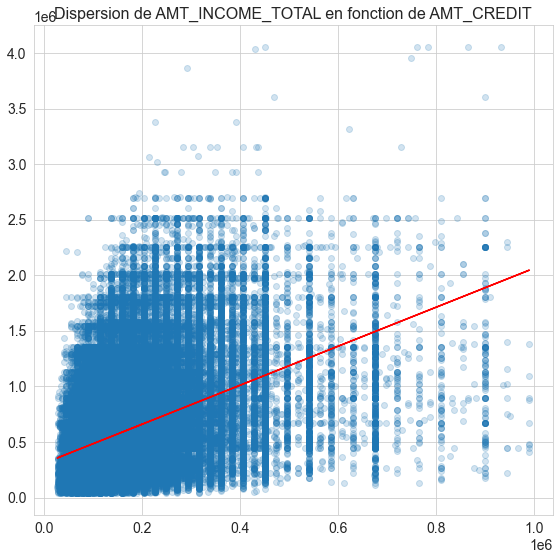

r2: 0.15
PearsonR: 0.39


In [121]:
plot_corr(app_train, 'AMT_INCOME_TOTAL', 'AMT_CREDIT')

Peu corrélé.

**Lien entre mensualités et montant du crédit**

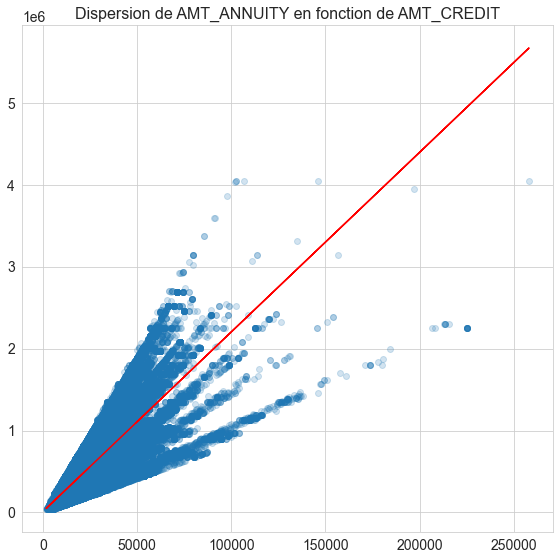

r2: 0.6
PearsonR: 0.77


In [122]:
plot_corr(app_train, 'AMT_ANNUITY', 'AMT_CREDIT')

Intéressant: il semble y avoir plusieurs modes de mensualités: chaque "ligne" que l'on voit correspond à un niveau de mensualité rélative au paiement. Cela correspond au termes du crédit.

In [123]:
app_train['RATIO_ANNUITY_CREDIT'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']

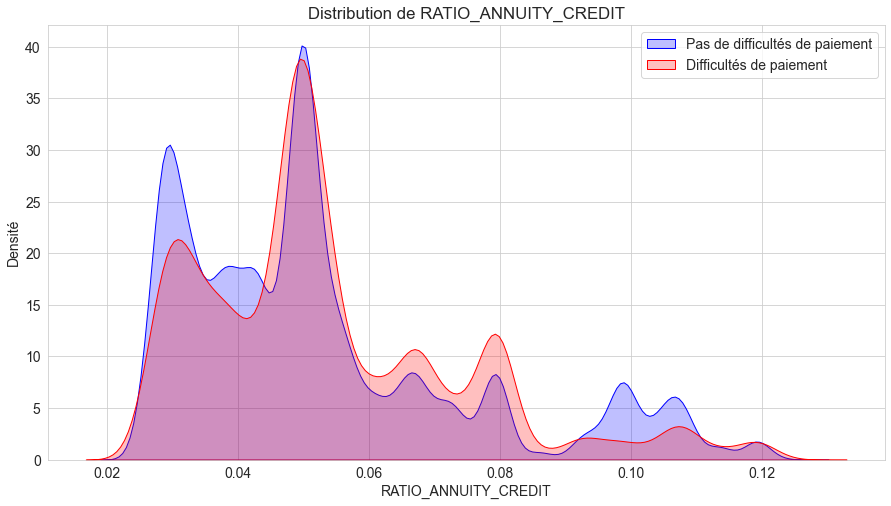

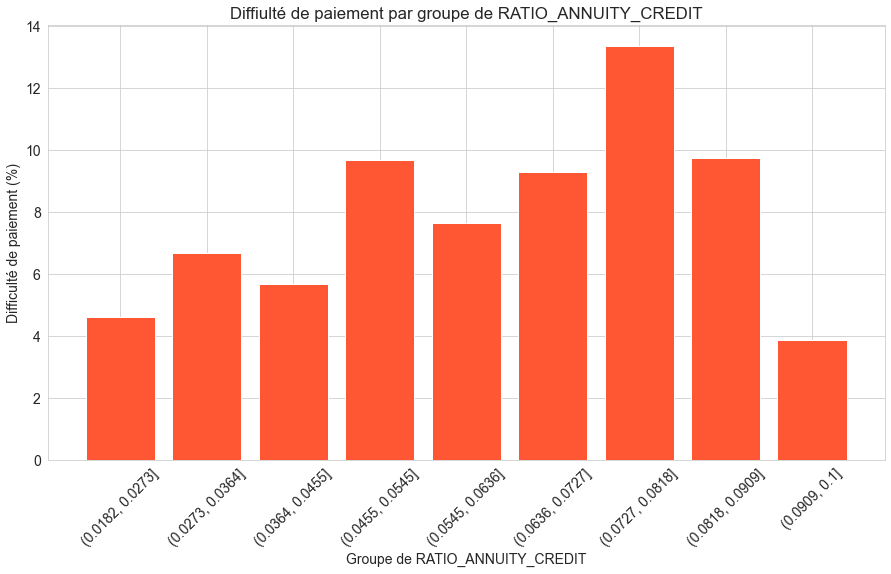

In [128]:
plot_dist(app_train, 'RATIO_ANNUITY_CREDIT', title='RATIO_ANNUITY_CREDIT')
plot_bar_default(app_train, 'RATIO_ANNUITY_CREDIT', n_bins=12)

**Lien entre revenu et montant du crédit**

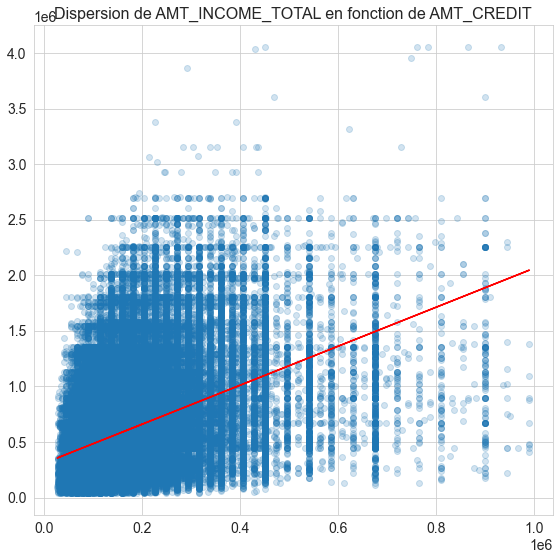

r2: 0.15
PearsonR: 0.39


In [129]:
plot_corr(app_train, 'AMT_INCOME_TOTAL', 'AMT_CREDIT')

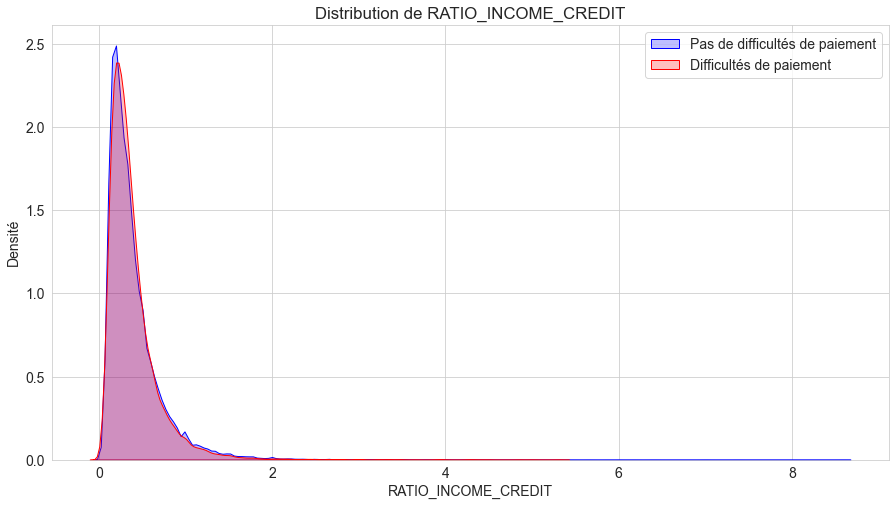

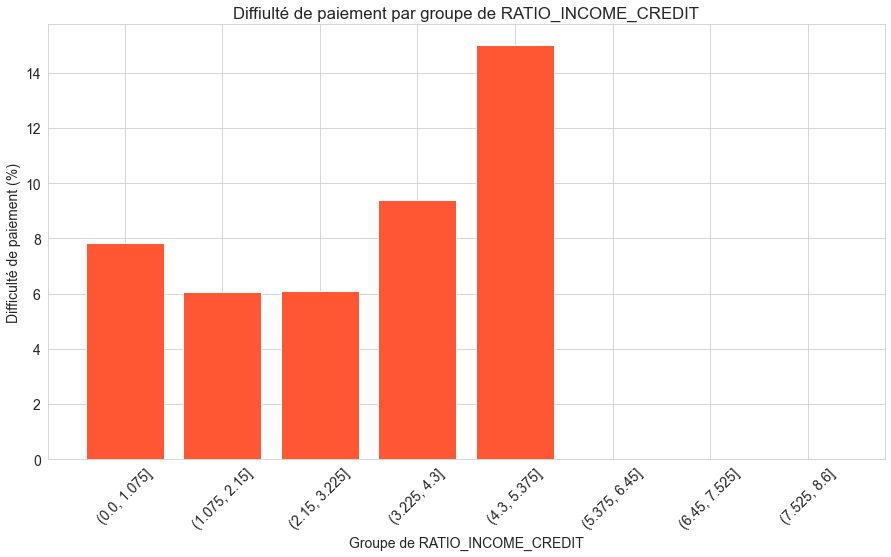

In [134]:
app_train['RATIO_INCOME_CREDIT'] = app_train['AMT_INCOME_TOTAL'] / app_train['AMT_CREDIT']
plot_dist(app_train, 'RATIO_INCOME_CREDIT', title='RATIO_INCOME_CREDIT')
plot_bar_default(app_train, 'RATIO_INCOME_CREDIT', n_bins=9)

**Lien entre revenu et mensualités du crédit**

In [136]:
plot_corr(app_train, 'AMT_INCOME_TOTAL', 'AMT_ANNUITY')

r2: 0.22
PearsonR: 0.47


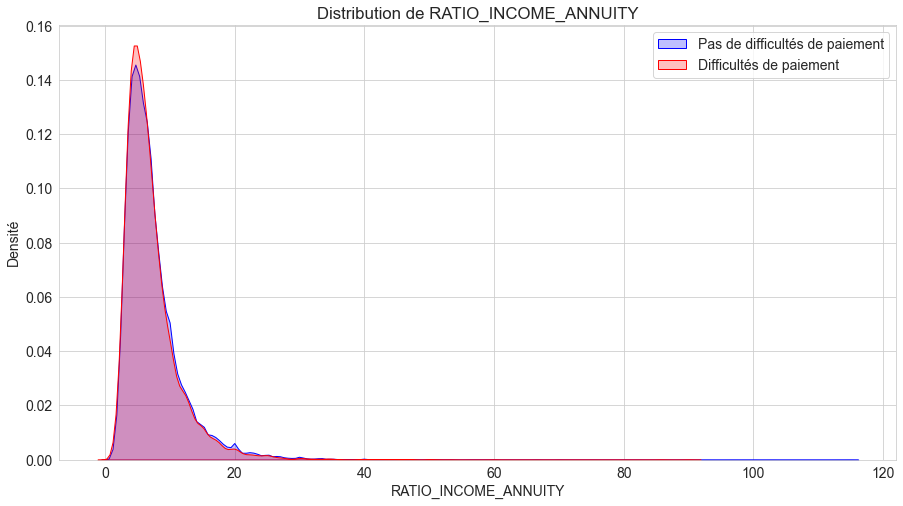

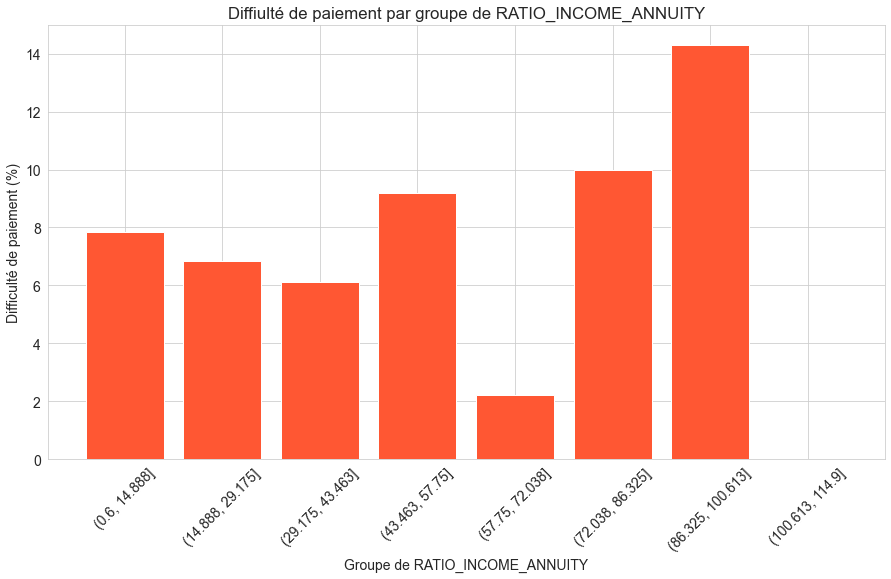

In [135]:
app_train['RATIO_INCOME_ANNUITY'] = app_train['AMT_INCOME_TOTAL'] / app_train['AMT_ANNUITY']
plot_dist(app_train, 'RATIO_INCOME_ANNUITY', title='RATIO_INCOME_ANNUITY')
plot_bar_default(app_train, 'RATIO_INCOME_ANNUITY', n_bins=9)

**Lien entre montant du crédit et montant des biens achetés avec le crédit**

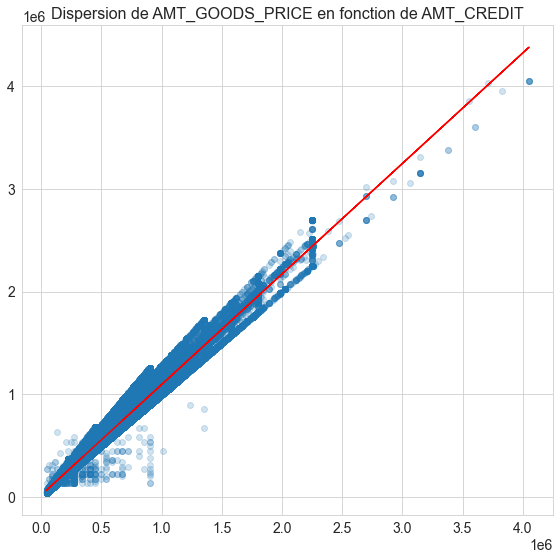

r2: 0.97
PearsonR: 0.99


In [138]:
plot_corr(app_train, 'AMT_GOODS_PRICE', 'AMT_CREDIT')

Ces deux variables sont extrêmement corrélées, nous en supprimerons une des deux.

In [139]:
app_train = app_train.drop('AMT_GOODS_PRICE', axis=1)

**Lien entre l'Age et le nombre de jours travaillés**

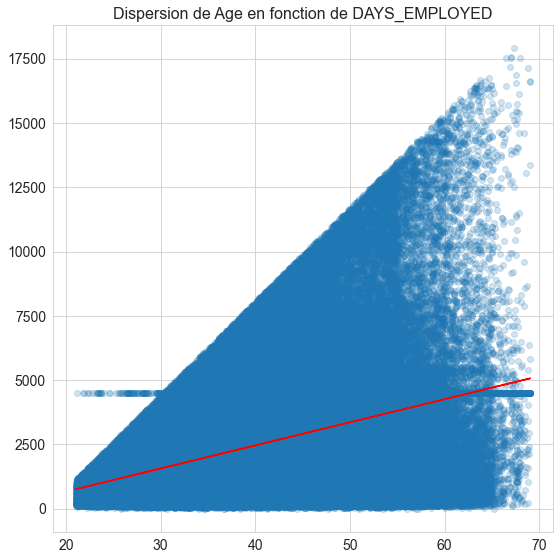

r2: 0.21
PearsonR: 0.46


In [140]:
plot_corr(app_train, 'Age', 'DAYS_EMPLOYED')

On observe ici une anomalie (ligne de points y=4500). Cela est due à l'imputation par la moyenne.

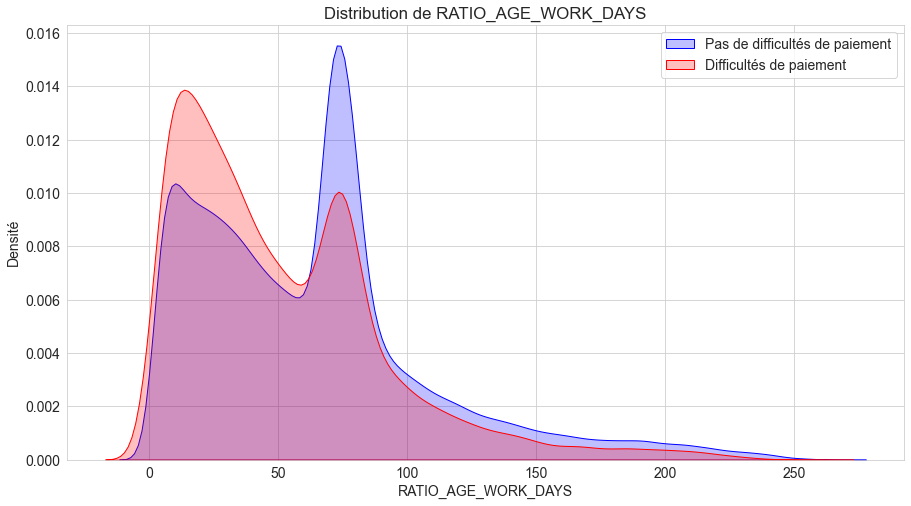

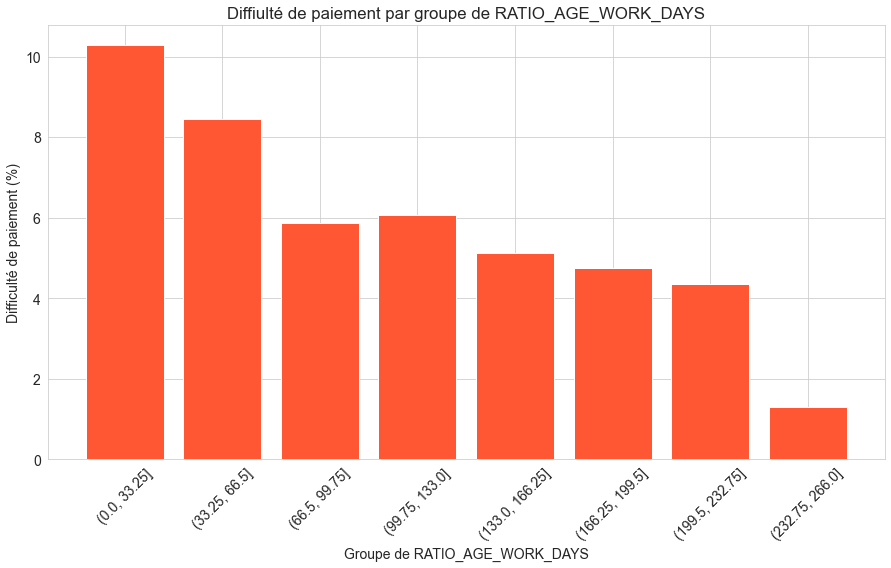

In [142]:
app_train['RATIO_AGE_WORK_DAYS'] = app_train['DAYS_EMPLOYED'] / app_train['Age']
plot_dist(app_train,'RATIO_AGE_WORK_DAYS', title='RATIO_AGE_WORK_DAYS')
plot_bar_default(app_train, 'RATIO_AGE_WORK_DAYS', n_bins=9)

Cette nouvelle variable semble avoir une forte influence sur la difficulté de remboursement.

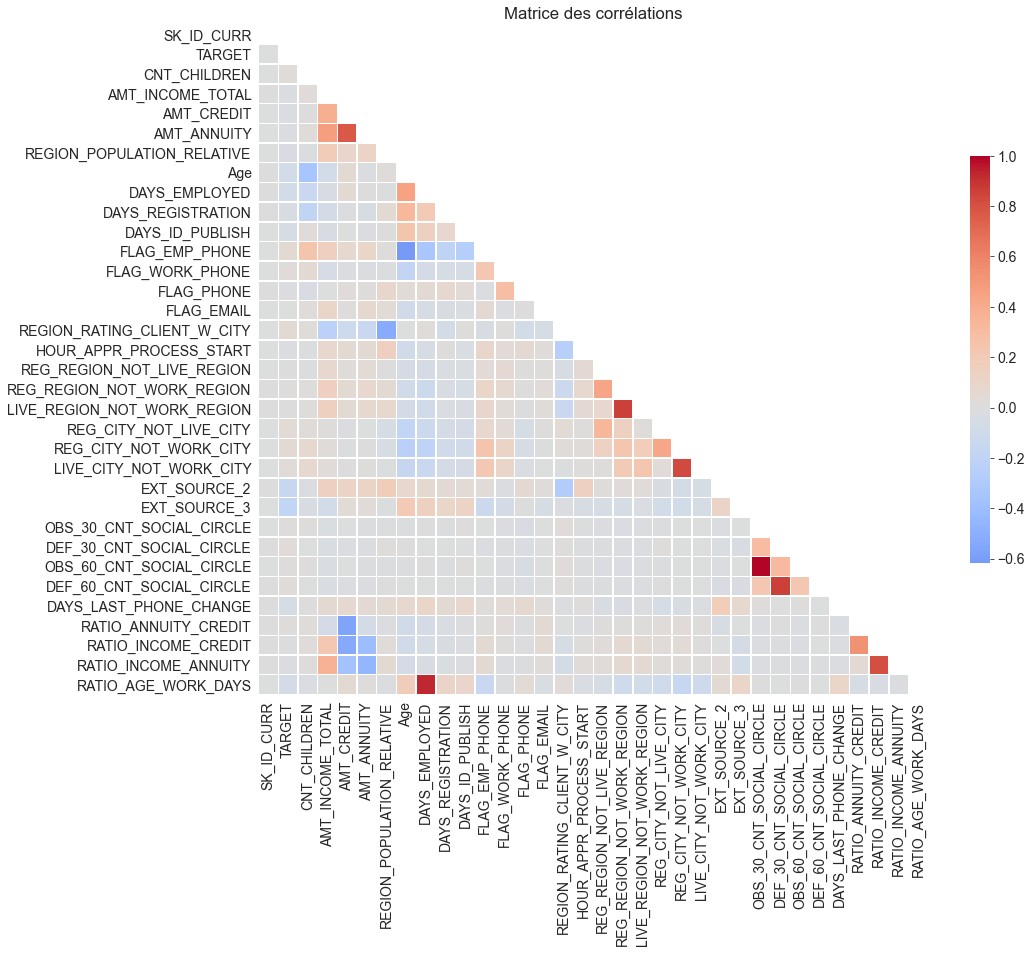

In [143]:
corr = app_train.corr()  # Coefficient de Pearson de chaque couple de variables
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Matrice des corrélations')
plt.show()

Nous pouvons désormais utiliser les données afin de prédire si un client est capable, ou non, de rembourser son crédit.

In [144]:
app_train.to_csv('clean_data.csv')